In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
# timesteps from 1h to 24h 
df = pd.read_csv("cleaned_data\\24timestep1h.csv", parse_dates=['tstp'])
df = df.drop(['date'], axis=1) # date column when joined with the holiday

# Single Household

In [15]:
singlehousehold_df_grp = df.groupby(['LCLid'])
singlehousehold_df = singlehousehold_df_grp.get_group('MAC003686')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# label encoding
precip_encoder = OneHotEncoder(sparse_output=False)
holiday_encoder = OneHotEncoder(sparse_output=False)
summary_encoder = OneHotEncoder(sparse_output=False)
household_encoder = LabelEncoder()
stdor_encoder = OneHotEncoder(sparse_output=False)
acorn_encoder = LabelEncoder()

precip_labels = precip_encoder.fit_transform(singlehousehold_df[['precipType']])
holiday_labels = holiday_encoder.fit_transform(singlehousehold_df[['Type']])
summary_labels = summary_encoder.fit_transform(singlehousehold_df[['summary']])
household_labels = household_encoder.fit_transform(singlehousehold_df[['LCLid']])
stdor_labels = stdor_encoder.fit_transform(singlehousehold_df[['stdorToU']])
acorn_labels = acorn_encoder.fit_transform(singlehousehold_df[['Acorn']])

precip_labels = pd.DataFrame(precip_labels, columns=precip_encoder.get_feature_names_out()).astype('int8')
holiday_labels = pd.DataFrame(holiday_labels, columns=holiday_encoder.get_feature_names_out()).astype('int8')
summary_labels = pd.DataFrame(summary_labels, columns=summary_encoder.get_feature_names_out()).astype('int8')
household_labels = pd.DataFrame(household_labels, columns=['household_label']).astype('int8')
stdor_labels = pd.DataFrame(stdor_labels, columns=stdor_encoder.get_feature_names_out()).astype('int8')
acorn_labels = pd.DataFrame(acorn_labels, columns=['acorn_label']).astype('int8')

encoded_df = pd.concat([singlehousehold_df, precip_labels, holiday_labels, summary_labels, household_labels, stdor_labels, acorn_labels], axis=1)
encoded_df = encoded_df.drop(['precipType', 'Type', 'summary', 'LCLid', 'stdorToU', 'Acorn'], axis=1)

c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

def create_fourier(date_index):
    fourier = CalendarFourier(
        freq='D',
        order=1
    )
    dp = DeterministicProcess(
        index=date_index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True
    )

    return dp

In [16]:
# scale the values
from sklearn.preprocessing import MinMaxScaler
import math

# split into train, test
cutoff_point = math.floor(encoded_df.shape[0] * 0.9)
training_singlehousehold_df = encoded_df.iloc[:cutoff_point].reset_index()
testing_singlehousehold_df = encoded_df.iloc[cutoff_point:].reset_index()

# creating fourier features
fourier_obj = create_fourier(training_singlehousehold_df.set_index('tstp').asfreq('h').index)
fourier_train_features = fourier_obj.in_sample().reset_index().drop(['tstp'], axis=1)
training_singlehousehold_df = pd.concat([training_singlehousehold_df, fourier_train_features], axis=1)
fourier_test_features = fourier_obj.out_of_sample(testing_singlehousehold_df.shape[0]).reset_index().drop(['index'], axis=1)
testing_singlehousehold_df = pd.concat([testing_singlehousehold_df.reset_index().drop(['index'], axis=1), fourier_test_features], axis=1)

training_singlehousehold_df = training_singlehousehold_df.drop(['index', 'tstp'], axis=1)
testing_singlehousehold_df = testing_singlehousehold_df.drop(['level_0', 'tstp'], axis=1)

# split into training and testing features
X_train = training_singlehousehold_df.drop(['energy(kWh/hh)'], axis=1)
y_train = training_singlehousehold_df['energy(kWh/hh)']
X_test = testing_singlehousehold_df.drop(['energy(kWh/hh)'], axis=1)
y_test = testing_singlehousehold_df['energy(kWh/hh)']

# Scale with MinMax Normalization
scaler = MinMaxScaler(feature_range=(0, 1)) # scale to 0 and 1
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (10770, 129)
X_test shape: (1197, 129)
y_train shape: (10770,)
y_test shape: (1197,)


In [169]:
from sklearn.metrics import (
   mean_absolute_percentage_error, 
   mean_absolute_error, 
   mean_squared_error, 
   r2_score,
   mean_pinball_loss
)

def adjusted_r2(y_pred, y_test):
   p = X_train.shape[1]
   r2 = r2_score(y_pred, y_test)
   n = y_test.shape[0]
   
   adjusted_coefficient = 1 - (1 - r2) * (n - 1) / (n - p - 1)

   return adjusted_coefficient

def evaluate_model(y_pred, y_test):
  """
    Evaluate the model predictions with all the regression metrics
  """

  print("RMSE:", mean_squared_error(y_pred['pred_0.5'], y_test, squared=False))
  print("MSE:", mean_squared_error(y_pred['pred_0.5'], y_test, squared=True))
  print("MAE:", mean_absolute_error(y_pred['pred_0.5'], y_test))
  print("MAPE:", mean_absolute_percentage_error(y_pred['pred_0.5'], y_test))
  print("Pinball loss with alpha 0.2:", mean_pinball_loss(y_pred['pred_0.2'], y_test, alpha=0.2))
  print("Pinball loss with alpha 0.5:", mean_pinball_loss(y_pred['pred_0.5'], y_test, alpha=0.5))
  print("Pinball loss with alpha 0.8:", mean_pinball_loss(y_pred['pred_0.8'], y_test, alpha=0.8))
  print("R2 Score:", r2_score(y_pred['pred_0.5'], y_test))
  print("Adjusted R2 Score:", adjusted_r2(y_pred['pred_0.5'], y_test))

def plot_forecast(y_pred, y_test, number_of_slices=3, steps=168, skip=0):
    """
      Plot the forecasted values against the truth values for LSTM and CNN-LSTM
    """
    fig, axes = plt.subplots(number_of_slices, 1, sharey=True, figsize=(14, 10))
    timesteps = np.arange(0, steps)
    
    for i in range(number_of_slices):
        start_idx = 0 + (steps * i) + (skip)
        end_idx = steps * (1 + i) + (skip)
        sampled_test = y_test.iloc[start_idx:end_idx]
        sampled_pred = y_pred.iloc[start_idx:end_idx]
        mape_score = mean_absolute_percentage_error(sampled_test, sampled_pred['pred_0.5'])
        
        sns.lineplot(x=timesteps, y=sampled_test, label="truth-value", marker='o', alpha=0.3, ax=axes[i])
        sns.lineplot(x=timesteps, y=sampled_pred['pred_0.5'], label="forecasted-median", marker='o', ax=axes[i])
        axes[i].fill_between(x=timesteps, y1=sampled_pred['pred_0.2'], y2=sampled_pred['pred_0.8'], alpha=0.1, color='blue')
        axes[i].set_title(f'MAPE: {round(mape_score, 2)}')

    plt.tight_layout()
    plt.show()
    

### Quantile-LightGBM

In [170]:
# Train with LightGBM

from lightgbm import LGBMRegressor

models = {}
alphas = [0.2, 0.5, 0.8]
df_pred = pd.DataFrame(y_test.copy(deep=True))

for i in alphas:
  model = LGBMRegressor(n_estimators=500, learning_rate=0.01, random_state=42, objective='quantile', alpha=i)
  model.fit(X_train, y_train)
  df_pred[f'pred_{str(i)}'] = model.predict(X_test)
  models[f'model_{str(i)}'] = model


In [172]:
evaluate_model(df_pred, y_test)

RMSE: 0.3374279811987755
MSE: 0.11385764249588118
MAE: 0.20034748861742868
MAPE: 0.20577447963252046
Pinball loss with alpha 0.2: 0.2689792810910546
Pinball loss with alpha 0.5: 0.10017374430871434
Pinball loss with alpha 0.8: 0.16499019600891687
R2 Score: -0.07239190220050706
Adjusted R2 Score: -0.2020437816605496


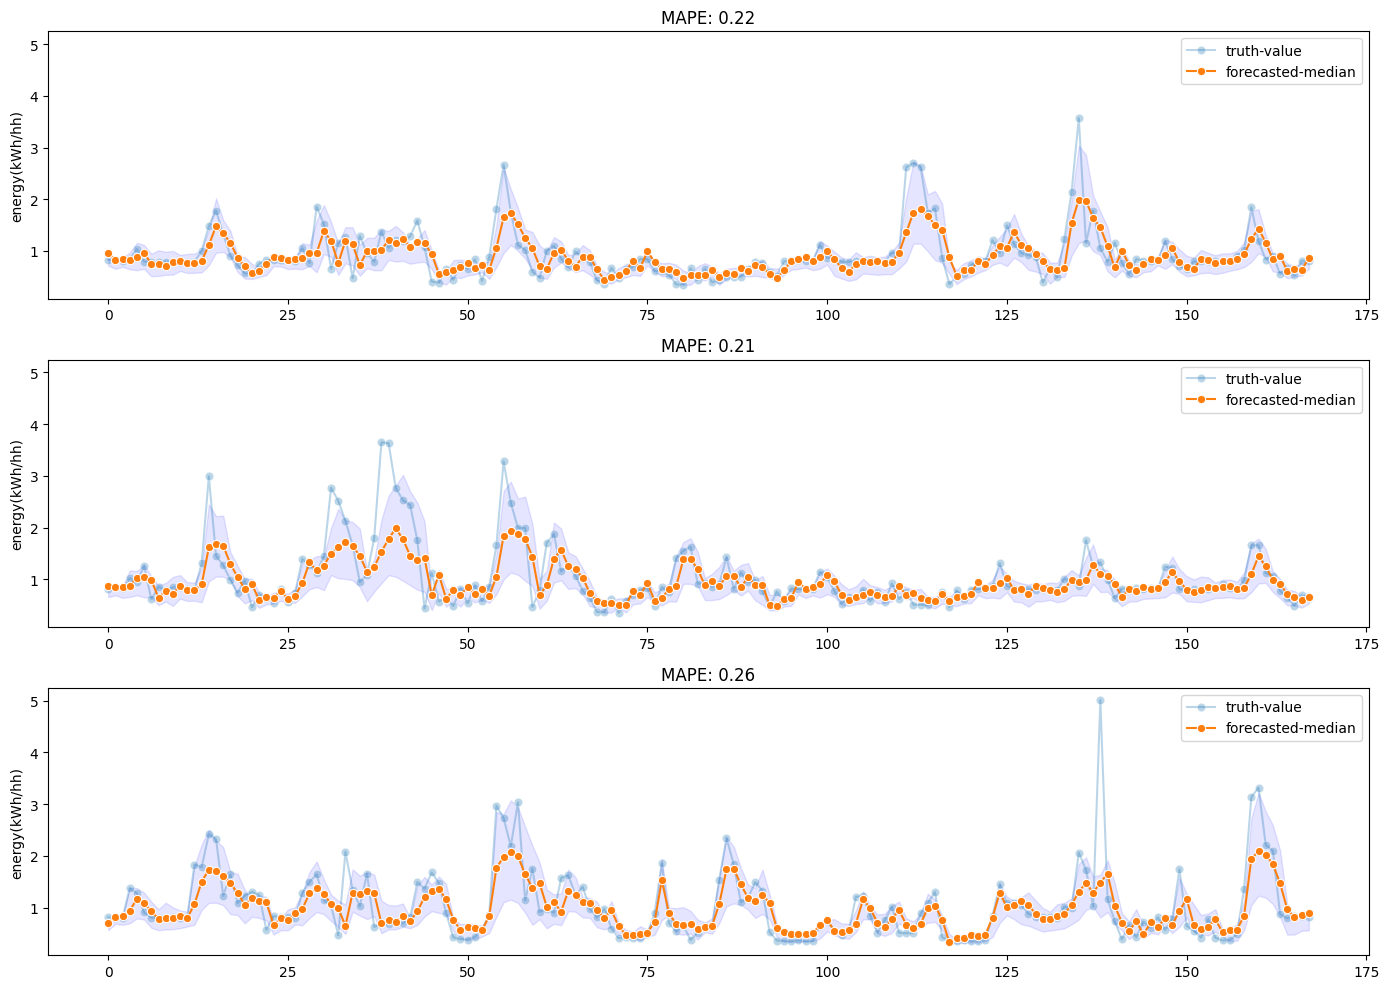

In [173]:
plot_forecast(df_pred, y_test, 3, 168, (3 * 168))

### Quantile-XGBoost 

In [174]:
from xgboost import XGBRegressor

models = {}
alphas = np.array([0.2, 0.5, 0.8])
df_pred = pd.DataFrame(y_test.copy(deep=True))

xgb = XGBRegressor(
  n_estimators=500, 
  learning_rate=0.01, 
  random_state=42, 
  objective='reg:quantileerror',
  quantile_alpha=alphas,
  n_jobs=5 # use multi-threaded
)

xgb.fit(X_train, y_train)

# make predictions and construct the dataframe
y_pred = xgb.predict(X_test)
df_pred = np.hstack([np.expand_dims(y_test, axis=1), y_pred])
df_pred = pd.DataFrame(df_pred, columns=['energy(kWh/hh)', 'pred_0.2', 'pred_0.5', 'pred_0.8'])
df_pred

energy(kWh/hh)  pred_0.2  pred_0.5  pred_0.8
0              0.751  0.611830  0.748574  0.823136
1              0.758  0.677526  0.776123  0.834740
2              0.750  0.617725  0.762751  0.848484
3              0.856  0.620731  0.767813  0.891534
4              0.886  0.662792  0.786951  0.935998
...              ...       ...       ...       ...
1192           1.130  0.820070  1.276632  1.451307
1193           1.128  0.840840  1.187251  1.355866
1194           1.123  0.824258  1.060789  1.328442
1195           1.375  0.736243  0.948138  1.187966
1196           0.435  0.760674  0.914516  1.032648

[1197 rows x 4 columns]

In [177]:
evaluate_model(df_pred, y_test)

RMSE: 0.3448124962444383
MSE: 0.1188956575663208
MAE: 0.209012448925774
MAPE: 0.2170259465491472
Pinball loss with alpha 0.2: 0.25984042217838055
Pinball loss with alpha 0.5: 0.104506224462887
Pinball loss with alpha 0.8: 0.1800884035510079
R2 Score: -0.1646394252998975
Adjusted R2 Score: -0.3054440043661457


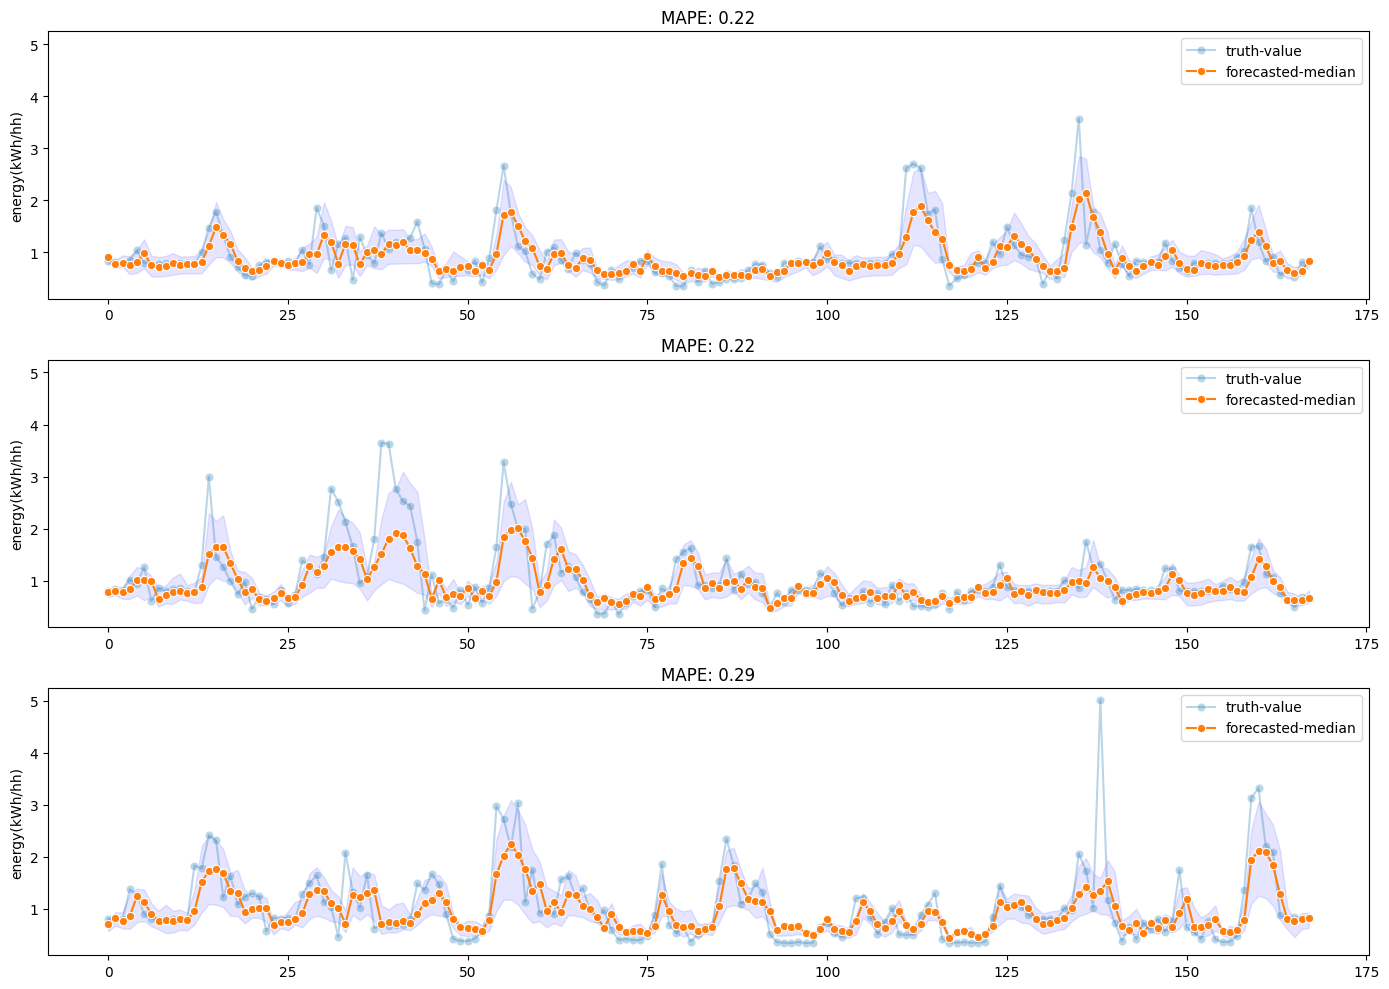

In [178]:
plot_forecast(df_pred, y_test, 3, 168, (3 * 168))

### Quantile LSTM

In [112]:
dl_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
dl_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print("DL Train Shape:", dl_train.shape)
print("DL Test Shape:", dl_test.shape)

DL Train Shape: (10770, 1, 129)
DL Test Shape: (1197, 1, 129)


In [110]:
import tensorflow as tf

def pinball_loss(y, y_hat, alpha):
  """
    Loss function for the deep learning models
  """

  error = (y - y_hat)
  loss = tf.keras.backend.mean(
    tf.keras.backend.maximum(alpha * error, (alpha - 1) * error), 
    axis=-1
  )

  return loss
  

In [180]:
from tensorflow.keras.layers import (
  Dense, LSTM, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_output_50_loss', patience=5)

### Create Model
input_layer = Input(shape=(1, dl_train.shape[2]))
layer = LSTM(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
  }
)

history = model.fit(
  dl_train,
  [y_train, y_train, y_train],
  epochs=50,
  validation_split=0.2,
  batch_size=32,
  callbacks=[earlystop]
)

Epoch 1/50
270/270 [==============================] - 4s 9ms/step - loss: 2.8048 - output_20_loss: 0.0722 - output_50_loss: 0.1440 - output_80_loss: 0.1511 - val_loss: 0.4536 - val_output_20_loss: 0.0851 - val_output_50_loss: 0.1555 - val_output_80_loss: 0.1384
Epoch 2/50
270/270 [==============================] - 2s 9ms/step - loss: 0.3458 - output_20_loss: 0.0640 - output_50_loss: 0.1160 - output_80_loss: 0.1075 - val_loss: 0.3968 - val_output_20_loss: 0.0810 - val_output_50_loss: 0.1387 - val_output_80_loss: 0.1264
Epoch 3/50
270/270 [==============================] - 3s 9ms/step - loss: 0.3137 - output_20_loss: 0.0607 - output_50_loss: 0.1063 - output_80_loss: 0.0968 - val_loss: 0.3899 - val_output_20_loss: 0.0799 - val_output_50_loss: 0.1369 - val_output_80_loss: 0.1254
Epoch 4/50
270/270 [==============================] - 2s 9ms/step - loss: 0.2966 - output_20_loss: 0.0591 - output_50_loss: 0.1011 - output_80_loss: 0.0911 - val_loss: 0.3532 - val_output_20_loss: 0.0745 - val_outp

In [181]:
model.evaluate(dl_test, [y_test, y_test, y_test])

38/38 [==============================] - 0s 8ms/step - loss: 0.1422 - output_20_loss: 0.0220 - output_50_loss: 0.0502 - output_80_loss: 0.0403


[0.14224275946617126,
 0.021963834762573242,
 0.0502435564994812,
 0.04033344238996506]

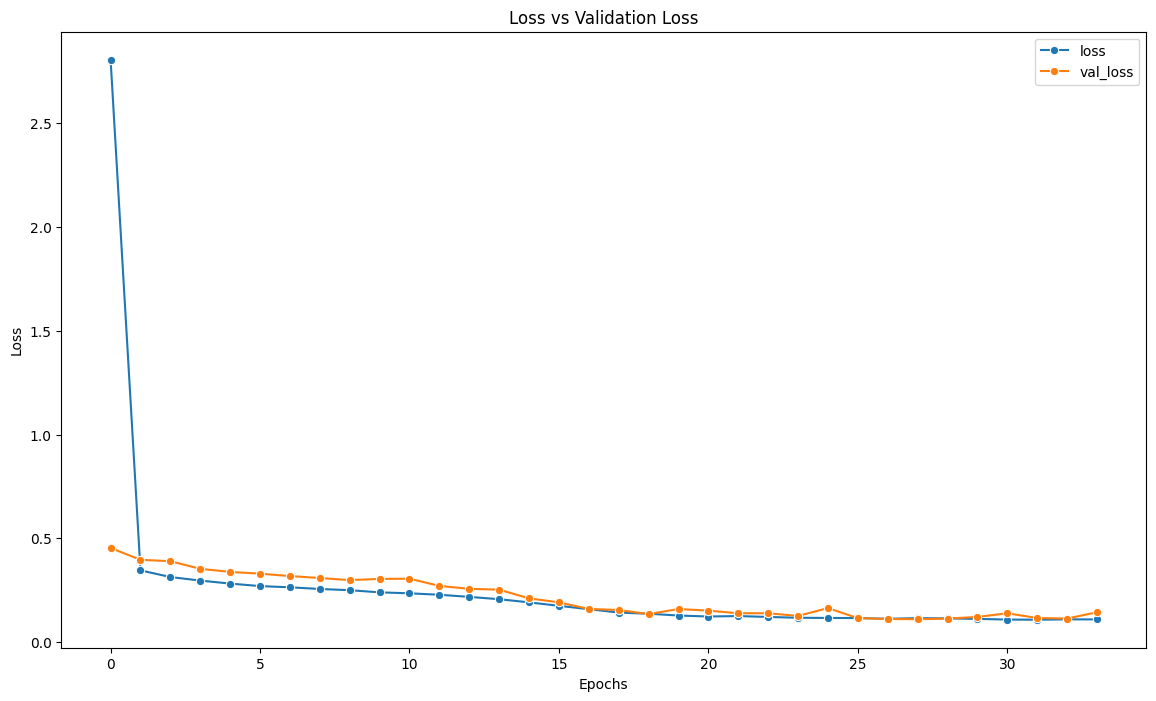

In [182]:
training_metrics = history.history
loss = training_metrics['loss']
val_loss = training_metrics['val_loss']


timesteps = np.arange(len(loss))
plt.figure(figsize=(14, 8))
sns.lineplot(x=timesteps, y=loss, label='loss', marker='o')
sns.lineplot(x=timesteps, y=val_loss, label='val_loss', marker='o')
plt.title("Loss vs Validation Loss")
plt.xlabel("Epochs")  
plt.ylabel("Loss")
plt.show()

In [185]:
y_pred = model.predict(dl_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional
y_pred = pd.DataFrame({
  'pred_0.2': y_pred[0].ravel(),
  'pred_0.5': y_pred[1].ravel(),
  'pred_0.8': y_pred[2].ravel()
})


38/38 [==============================] - 1s 9ms/step


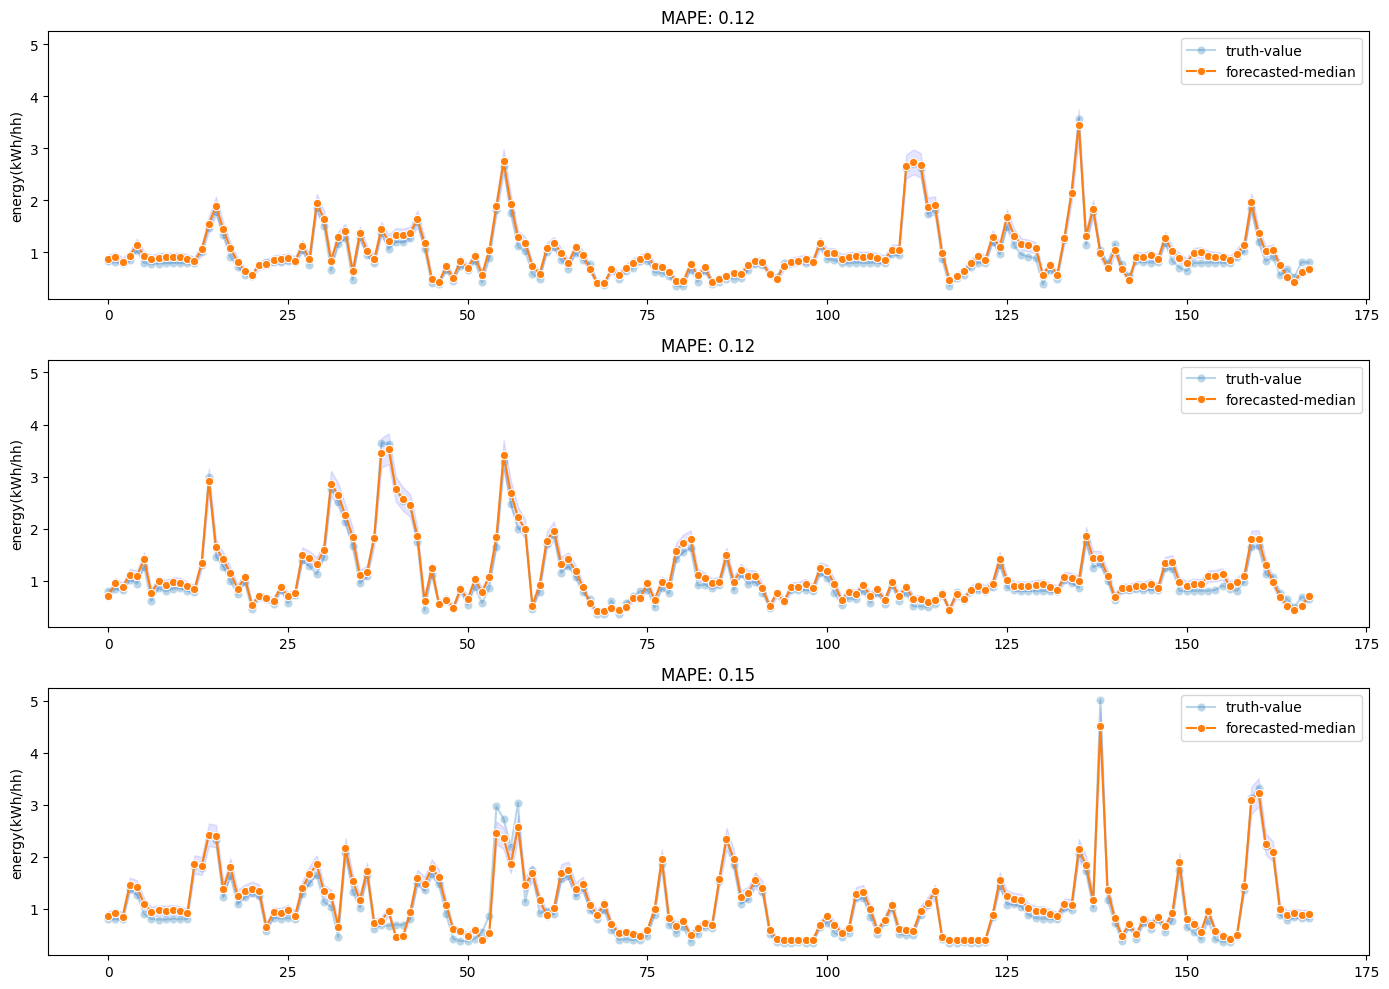

In [187]:
plot_forecast(y_pred, y_test, 3, 168, (3 * 168))

In [190]:
evaluate_model(y_pred, y_test)

RMSE: 0.11480587890545041
MSE: 0.013180389831252942
MAE: 0.10048711828383317
MAPE: 0.10935813867439302
Pinball loss with alpha 0.2: 0.03202701874958267
Pinball loss with alpha 0.5: 0.05024355914191658
Pinball loss with alpha 0.8: 0.15396550069250442
R2 Score: 0.9512231517364125
Adjusted R2 Score: 0.9453260444955476


### Quantile-GRU

In [191]:
from tensorflow.keras.layers import (
  Dense, GRU, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_output_50_loss', patience=5)

### Create Model
input_layer = Input(shape=(1, dl_train.shape[2]))
layer = GRU(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
  }
)

history = model.fit(
  dl_train,
  [y_train, y_train, y_train],
  epochs=50,
  validation_split=0.2,
  batch_size=32,
  callbacks=[earlystop]
)

Epoch 1/50
270/270 [==============================] - 4s 9ms/step - loss: 2.8257 - output_20_loss: 0.0715 - output_50_loss: 0.1402 - output_80_loss: 0.1453 - val_loss: 0.4495 - val_output_20_loss: 0.0829 - val_output_50_loss: 0.1511 - val_output_80_loss: 0.1367
Epoch 2/50
270/270 [==============================] - 2s 9ms/step - loss: 0.3394 - output_20_loss: 0.0629 - output_50_loss: 0.1122 - output_80_loss: 0.1038 - val_loss: 0.4008 - val_output_20_loss: 0.0811 - val_output_50_loss: 0.1387 - val_output_80_loss: 0.1253
Epoch 3/50
270/270 [==============================] - 2s 9ms/step - loss: 0.3076 - output_20_loss: 0.0596 - output_50_loss: 0.1034 - output_80_loss: 0.0932 - val_loss: 0.3878 - val_output_20_loss: 0.0794 - val_output_50_loss: 0.1375 - val_output_80_loss: 0.1238
Epoch 4/50
270/270 [==============================] - 2s 8ms/step - loss: 0.2929 - output_20_loss: 0.0580 - output_50_loss: 0.0987 - output_80_loss: 0.0884 - val_loss: 0.3593 - val_output_20_loss: 0.0750 - val_outp

In [163]:
model.evaluate(dl_test, [y_test, y_test, y_test])

38/38 [==============================] - 0s 6ms/step - loss: 0.1307 - output_20_loss: 0.0318 - output_50_loss: 0.0443 - output_80_loss: 0.0236


[0.13065485656261444,
 0.03177822381258011,
 0.044290315359830856,
 0.02357005886733532]

In [164]:
y_pred = model.predict(dl_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional
y_pred = pd.DataFrame({
  'pred_0.2': y_pred[0].ravel(),
  'pred_0.5': y_pred[1].ravel(),
  'pred_0.8': y_pred[2].ravel()
})


38/38 [==============================] - 0s 4ms/step


In [167]:
evaluate_model(y_pred['pred_0.5'], y_test, deep_learning=True)

RMSE: 0.11252119526877147
MSE: 0.012661019384713
MAE: 0.0885806281323267
MAPE: 0.11490623654244661
Pinball loss with alpha 0.2: 0.06837644818361802
Pinball loss with alpha 0.5: 0.04429031406616335
Pinball loss with alpha 0.8: 0.020204179948708705
R2 Score: 0.9472257830747864
Adjusted R2 Score: 0.9408453950866398


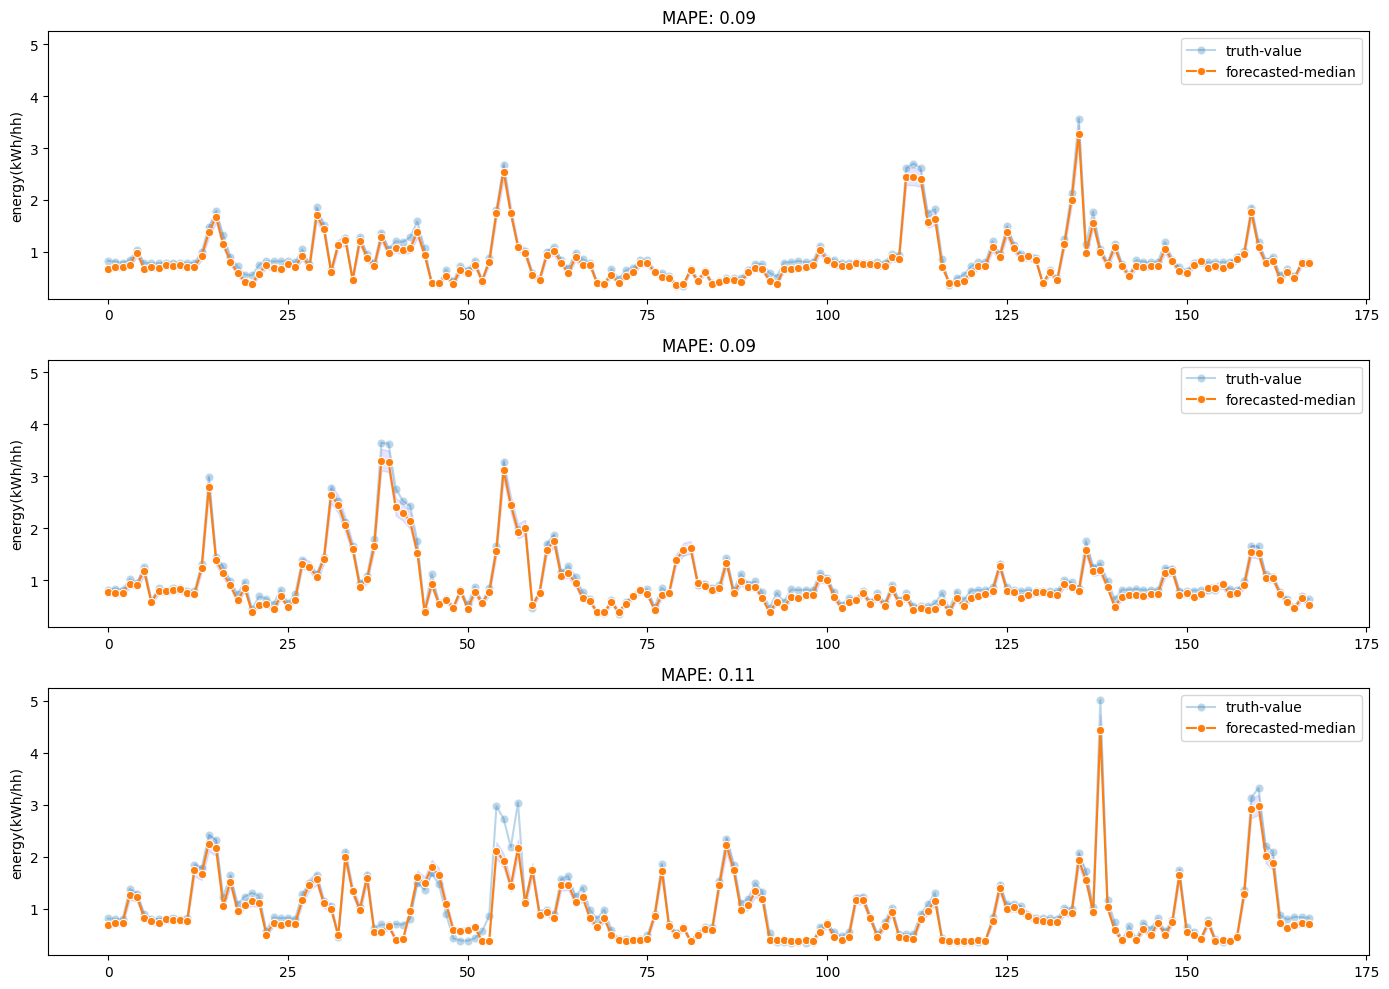

In [165]:
plot_forecast(y_pred, y_test, 3, 168, (3 * 168))

# Multiple Households

In [3]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

def create_fourier(date_index):
    fourier = CalendarFourier(
        freq='D',
        order=1
    )
    dp = DeterministicProcess(
        index=date_index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True
    )

    return dp

In [4]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# label encoding
precip_encoder = OneHotEncoder(sparse_output=False)
holiday_encoder = OneHotEncoder(sparse_output=False)
summary_encoder = OneHotEncoder(sparse_output=False)
household_encoder = LabelEncoder()
stdor_encoder = OneHotEncoder(sparse_output=False)
acorn_encoder = LabelEncoder()

precip_labels = precip_encoder.fit_transform(df[['precipType']])
holiday_labels = holiday_encoder.fit_transform(df[['Type']])
summary_labels = summary_encoder.fit_transform(df[['summary']])
household_labels = household_encoder.fit_transform(df[['LCLid']])
stdor_labels = stdor_encoder.fit_transform(df[['stdorToU']])
acorn_labels = acorn_encoder.fit_transform(df[['Acorn']])

precip_labels = pd.DataFrame(precip_labels, columns=precip_encoder.get_feature_names_out()).astype('int8')
holiday_labels = pd.DataFrame(holiday_labels, columns=holiday_encoder.get_feature_names_out()).astype('int8')
summary_labels = pd.DataFrame(summary_labels, columns=summary_encoder.get_feature_names_out()).astype('int8')
household_labels = pd.DataFrame(household_labels, columns=['household_label']).astype('int8')
stdor_labels = pd.DataFrame(stdor_labels, columns=stdor_encoder.get_feature_names_out()).astype('int8')
acorn_labels = pd.DataFrame(acorn_labels, columns=['acorn_label']).astype('int8')

encoded_df = pd.concat([df, precip_labels, holiday_labels, summary_labels, household_labels, stdor_labels, acorn_labels], axis=1)
encoded_df = encoded_df.drop(['precipType', 'Type', 'summary', 'LCLid', 'stdorToU', 'Acorn'], axis=1)

c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
# process fourier features for each group and saved each group's deterministic process
import math

dps = {}

all_household_ids = encoded_df['household_label'].unique()
households_grp = encoded_df.groupby('household_label')
training_df = []
testing_df = []

for household_id in all_household_ids:
    # get the household from the entire df
    print("Household id:", household_id)
    singlehousehold_df = households_grp.get_group(household_id).sort_values(by='tstp', ascending=True)

    # split into train, test
    cutoff_point = math.floor(singlehousehold_df.shape[0] * 0.9)
    training_singlehousehold_df = singlehousehold_df.iloc[:cutoff_point].reset_index()
    testing_singlehousehold_df = singlehousehold_df.iloc[cutoff_point:].reset_index()

    # create fourier features
    fourier_obj = create_fourier(training_singlehousehold_df.set_index('tstp').asfreq('h').index)
    fourier_train_features = fourier_obj.in_sample().reset_index().drop(['tstp'], axis=1)
    training_singlehousehold_df = pd.concat([training_singlehousehold_df, fourier_train_features], axis=1)
    fourier_test_features = fourier_obj.out_of_sample(testing_singlehousehold_df.shape[0]).reset_index().drop(['index'], axis=1)
    testing_singlehousehold_df = pd.concat([testing_singlehousehold_df.reset_index().drop(['index'], axis=1), fourier_test_features], axis=1)
    
    # save the dp object
    dps[household_id] = fourier_obj

    # append to the household_dfs list
    training_df.append(training_singlehousehold_df)
    testing_df.append(testing_singlehousehold_df)

training_df = pd.concat(training_df, axis=0)
testing_df = pd.concat(testing_df, axis=0)

Household id: 35
Household id: 30
Household id: 14
Household id: 46
Household id: 41
Household id: 24
Household id: 26
Household id: 37
Household id: 6
Household id: 45
Household id: 19
Household id: 3
Household id: 39
Household id: 32
Household id: 8
Household id: 22
Household id: 11
Household id: 38
Household id: 42
Household id: 10
Household id: 15
Household id: 16
Household id: 29
Household id: 36
Household id: 1
Household id: 23
Household id: 31
Household id: 28
Household id: 21
Household id: 7
Household id: 49
Household id: 17
Household id: 27
Household id: 0
Household id: 44
Household id: 5
Household id: 40
Household id: 12
Household id: 48
Household id: 33
Household id: 13
Household id: 2
Household id: 50
Household id: 43
Household id: 25
Household id: 34
Household id: 20
Household id: 18
Household id: 4
Household id: 9
Household id: 47


In [6]:
# scale the values
from sklearn.preprocessing import MinMaxScaler

# drop unnecessary columns
training_df = training_df.drop(['index', 'tstp'], axis=1)
testing_df = testing_df.drop(['level_0', 'tstp'], axis=1)

# separate into features and target
X_train = training_df.drop(['energy(kWh/hh)'], axis=1)
X_test = testing_df.drop(['energy(kWh/hh)'], axis=1)
y_train = training_df['energy(kWh/hh)']
y_test = testing_df['energy(kWh/hh)']

# store the household ids for future evaluation
test_household_ids = X_test['household_label']
train_household_ids = X_train['household_label']

# Scale with MinMax Normalization
scaler = MinMaxScaler(feature_range=(0, 1)) # scale to 0 and 1
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshape for LSTM, CNN-LSTM models
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape)
print(X_test.shape)

(686587, 1, 134)
(76315, 1, 134)


## Modelling

In [7]:
from sklearn.metrics import (
   mean_absolute_percentage_error, 
   mean_absolute_error, 
   mean_squared_error, 
   r2_score,
   mean_pinball_loss
)

def adjusted_r2(y_pred, y_test):
   p = X_train.shape[1]
   r2 = r2_score(y_pred, y_test)
   n = y_test.shape[0]
   
   adjusted_coefficient = 1 - (1 - r2) * (n - 1) / (n - p - 1)

   return adjusted_coefficient

def evaluate_model(y_pred, y_test):
  """
    Evaluate the model predictions with all the regression metrics
  """

  print("RMSE:", mean_squared_error(y_pred['pred_0.5'], y_test, squared=False))
  print("MSE:", mean_squared_error(y_pred['pred_0.5'], y_test, squared=True))
  print("MAE:", mean_absolute_error(y_pred['pred_0.5'], y_test))
  print("MAPE:", mean_absolute_percentage_error(y_pred['pred_0.5'], y_test))
  print("R2 Score:", r2_score(y_pred['pred_0.5'], y_test))
  print("Adjusted R2 Score:", adjusted_r2(y_pred['pred_0.5'], y_test))

  print("Pinball loss with alpha 0.2:", mean_pinball_loss(y_pred['pred_0.2'], y_test, alpha=0.2))
  print("Pinball loss with alpha 0.5:", mean_pinball_loss(y_pred['pred_0.5'], y_test, alpha=0.5))
  print("Pinball loss with alpha 0.8:", mean_pinball_loss(y_pred['pred_0.8'], y_test, alpha=0.8))

def plot_forecast(y_pred, y_test, number_of_slices=3, steps=168, skip=0):
    """
      Plot the forecasted values against the truth values for LSTM and CNN-LSTM
    """
    fig, axes = plt.subplots(number_of_slices, 1, sharey=True, figsize=(14, 10))
    timesteps = np.arange(0, steps)
    
    for i in range(number_of_slices):
        start_idx = 0 + (steps * i) + (skip)
        end_idx = steps * (1 + i) + (skip)
        sampled_test = y_test.iloc[start_idx:end_idx]
        sampled_pred = y_pred.iloc[start_idx:end_idx]
        mape_score = mean_absolute_percentage_error(sampled_test, sampled_pred['pred_0.5'])
        
        sns.lineplot(x=timesteps, y=sampled_test, label="truth-value", marker='o', alpha=0.3, ax=axes[i])
        sns.lineplot(x=timesteps, y=sampled_pred['pred_0.5'], label="forecasted-median", marker='o', ax=axes[i])
        axes[i].fill_between(x=timesteps, y1=sampled_pred['pred_0.2'], y2=sampled_pred['pred_0.8'], alpha=0.1, color='blue')
        axes[i].set_title(f'MAPE: {round(mape_score, 2)}')

    plt.tight_layout()
    plt.show()
    

### Quantile-XGBoost

In [198]:
# reshape back to the original shape for XGBoost
ml_train = X_train.reshape(X_train.shape[0], X_train.shape[2]) 
ml_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

from xgboost import XGBRegressor

alphas = np.array([0.2, 0.5, 0.8])

xgb = XGBRegressor(
  n_estimators=500, 
  learning_rate=0.01, 
  random_state=42, 
  objective='reg:quantileerror',
  quantile_alpha=alphas,
  n_jobs=5 # use multi-threaded
)

# fit the model
xgb.fit(ml_train, y_train)

# make predictions and construct the dataframe
y_pred = xgb.predict(ml_test)
y_pred = pd.DataFrame(y_pred, columns=['pred_0.2', 'pred_0.5', 'pred_0.8'])
y_pred


pred_0.2  pred_0.5  pred_0.8
0      0.663495  0.807594  0.861097
1      0.651582  0.801977  0.853716
2      0.655083  0.776204  0.851463
3      0.695733  0.837637  0.952570
4      0.679561  0.856915  1.016309
...         ...       ...       ...
76310  0.039490  0.062846  0.102165
76311  0.037923  0.059669  0.089695
76312  0.038282  0.060403  0.089965
76313  0.038946  0.062860  0.084936
76314  0.042454  0.075609  0.066520

[76315 rows x 3 columns]

In [199]:
evaluate_model(y_pred, y_test)

RMSE: 0.365235355748986
MSE: 0.13339686508908838
MAE: 0.15231694407341295
MAPE: 0.3185031798968105
R2 Score: 0.3124613946741076
Adjusted R2 Score: 0.3124523852182439
Pinball loss with alpha 0.2: 0.16870083377631462
Pinball loss with alpha 0.5: 0.07615847203670648
Pinball loss with alpha 0.8: 0.11388049948303136


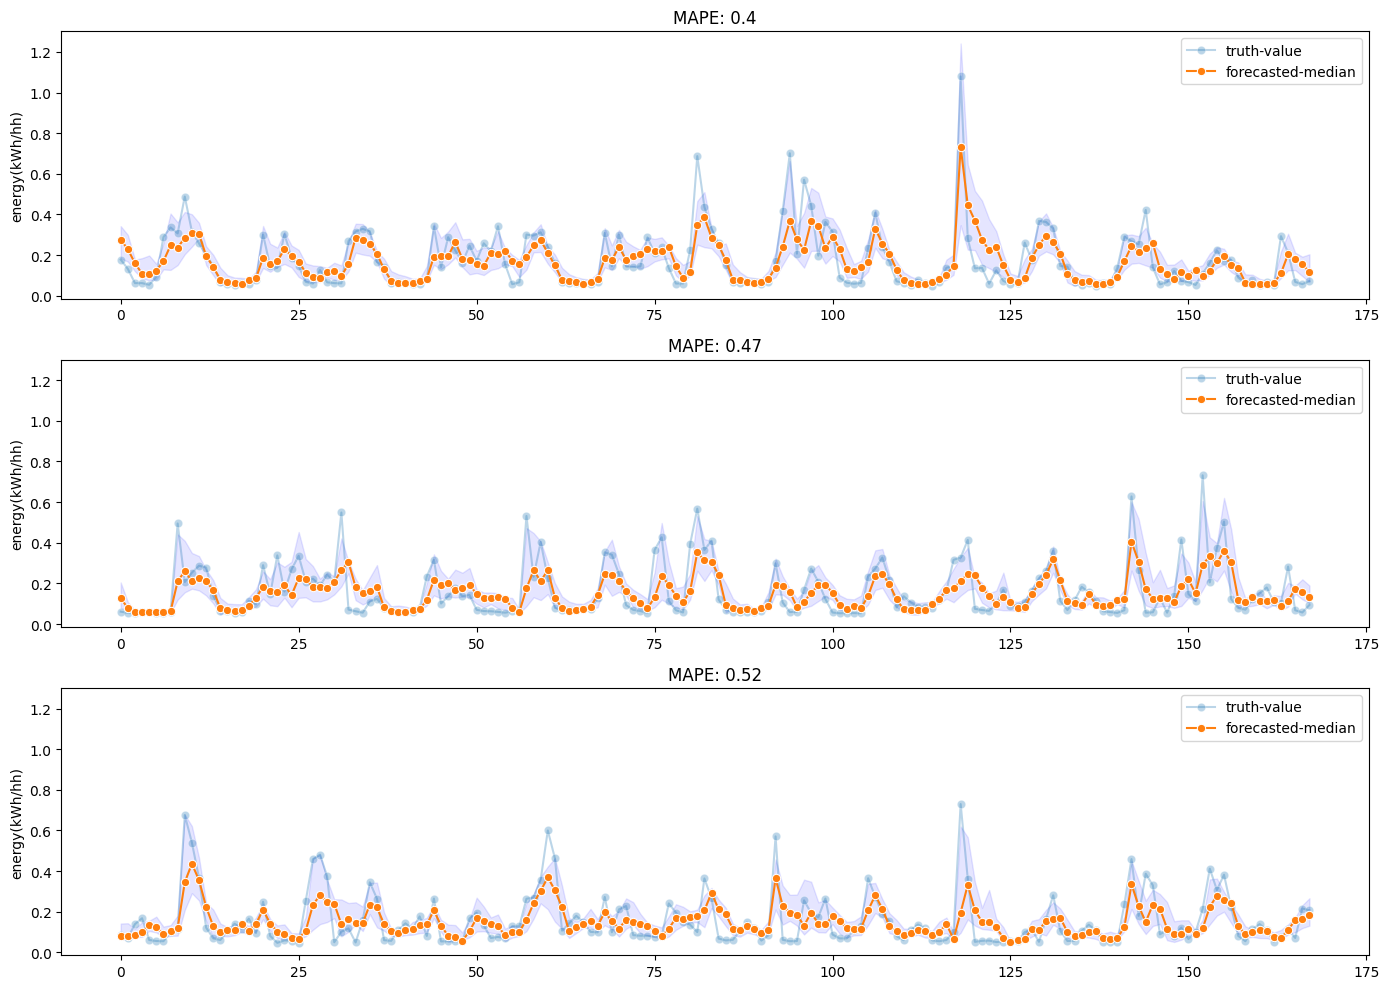

In [201]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

### Quantile-LightGBM

In [203]:
# Train with LightGBM

from lightgbm import LGBMRegressor

models = {}
alphas = [0.2, 0.5, 0.8]
y_pred = {}

for alpha in alphas:
  model = LGBMRegressor(
    n_estimators=500, 
    learning_rate=0.01, 
    random_state=42, 
    objective='quantile', 
    alpha=alpha
  )
  model.fit(ml_train, y_train)
  y_pred[f'pred_{str(alpha)}'] = model.predict(ml_test)
  models[f'model_{str(alpha)}'] = model
  print(f"Model_{str(alpha)} trained successfully...")

y_pred = pd.DataFrame(y_pred)
y_pred

Model_0.2 trained successfully...
Model_0.5 trained successfully...
Model_0.8 trained successfully...


pred_0.2  pred_0.5  pred_0.8
0      0.682513  0.772395  0.826925
1      0.671645  0.780561  0.813592
2      0.674645  0.796272  0.773859
3      0.680897  0.809750  0.865334
4      0.712088  0.841378  0.967084
...         ...       ...       ...
76310  0.022103  0.050922  0.082494
76311  0.026075  0.047434  0.077470
76312  0.037651  0.053024  0.085950
76313  0.037410  0.063958  0.085913
76314  0.079256  0.055327  0.090447

[76315 rows x 3 columns]

In [204]:
evaluate_model(y_pred, y_test)

RMSE: 0.3791465180481349
MSE: 0.14375208214802465
MAE: 0.1522765918629734
MAPE: 0.3143023788112093
R2 Score: 0.2263028625868605
Adjusted R2 Score: 0.22629272411586066
Pinball loss with alpha 0.2: 0.17112476401753277
Pinball loss with alpha 0.5: 0.0761382959314867
Pinball loss with alpha 0.8: 0.12415850777815705


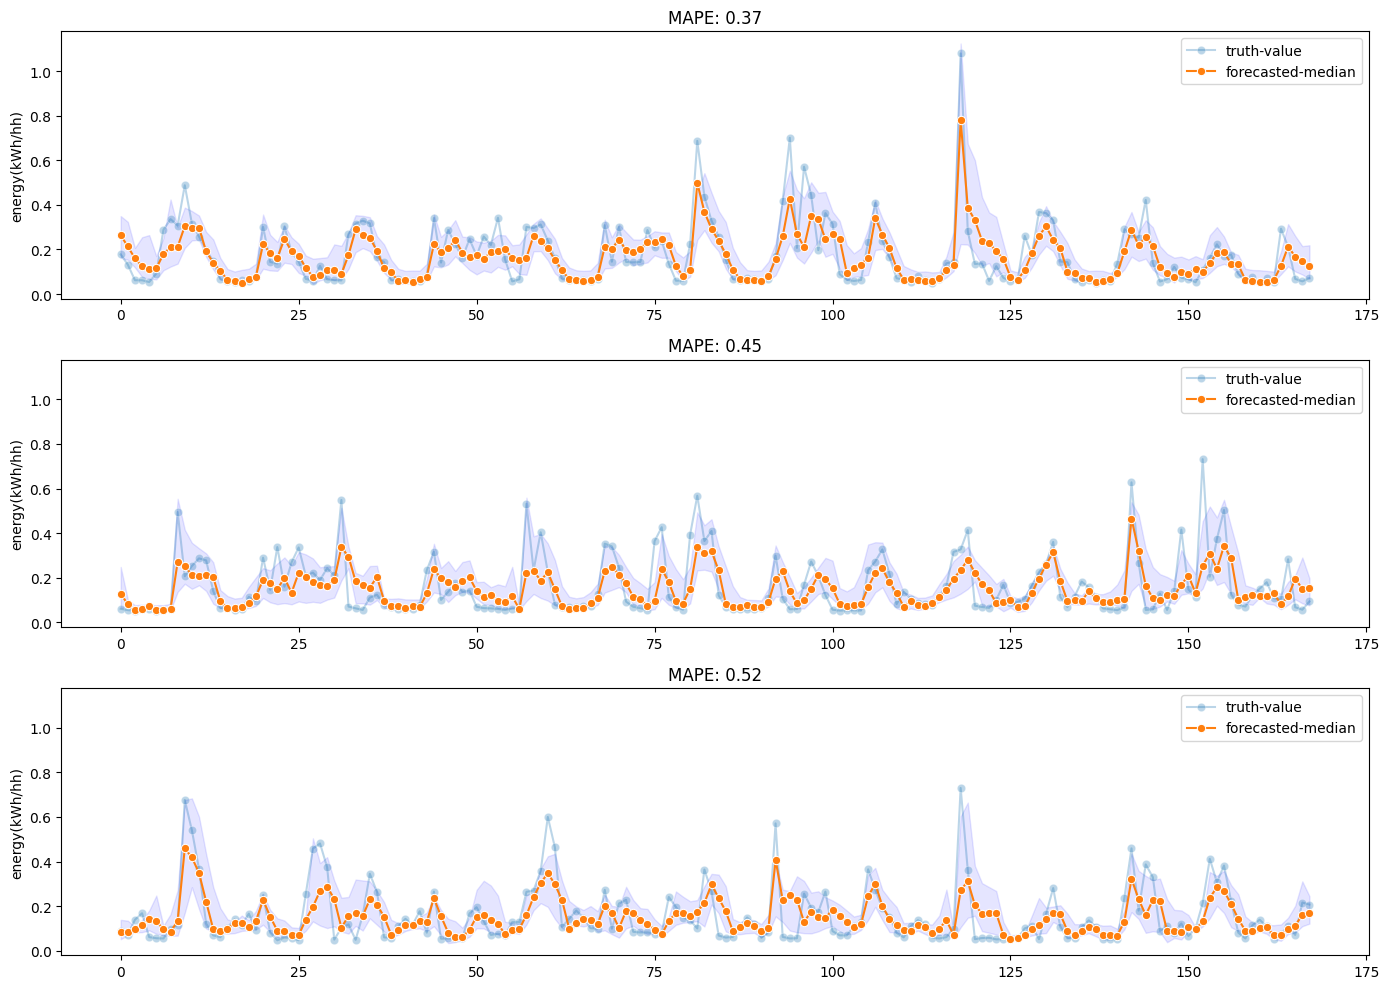

In [205]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

### Quantile-LSTM

In [27]:
import tensorflow as tf

def pinball_loss(y, y_hat, alpha):
  """
    Loss function for the deep learning models
  """

  error = (y - y_hat)
  loss = tf.keras.backend.mean(
    tf.keras.backend.maximum(alpha * error, (alpha - 1) * error), 
    axis=-1
  )

  return loss

def plot_training_metrics(history):
  """
    Function to plot the training metrics of the deep learning models
  """
  training_metrics = history.history
  loss = training_metrics['loss']
  val_loss = training_metrics['val_loss']
  loss_20 = training_metrics['output_20_loss']
  val_loss_20 = training_metrics['val_output_20_loss']
  loss_50 = training_metrics['output_50_loss']
  val_loss_50 = training_metrics['val_output_50_loss']
  loss_80 = training_metrics['output_80_loss']
  val_loss_80 = training_metrics['val_output_80_loss']


  timesteps = np.arange(len(loss))
  fig, axes = plt.subplots(2, 2, sharey=True, figsize=(14, 10))

  sns.lineplot(x=timesteps, y=loss, label='loss', marker='o', ax=axes[0][0])
  sns.lineplot(x=timesteps, y=val_loss, label='val_loss', marker='o', ax=axes[0][0])
  axes[0][0].set_title("Loss vs Validation Loss")
  axes[0][0].set_xlabel("Epochs")  
  axes[0][0].set_ylabel("Overall Loss")

  sns.lineplot(x=timesteps, y=loss_20, label='loss_20', marker='o', ax=axes[0][1])
  sns.lineplot(x=timesteps, y=val_loss_20, label='val_loss_20', marker='o', ax=axes[0][1])
  axes[0][1].set_title("Loss vs Validation Loss; alpha=0.2")
  axes[0][1].set_xlabel("Epochs")  
  axes[0][1].set_ylabel("Pinball Loss")

  sns.lineplot(x=timesteps, y=loss_50, label='loss_50', marker='o', ax=axes[1][0])
  sns.lineplot(x=timesteps, y=val_loss_50, label='val_loss_50', marker='o', ax=axes[1][0])
  axes[1][0].set_title("Loss vs Validation Loss; alpha=0.5")
  axes[1][0].set_xlabel("Epochs")  
  axes[1][0].set_ylabel("Pinball Loss")

  sns.lineplot(x=timesteps, y=loss_80, label='loss_80', marker='o', ax=axes[1][1])
  sns.lineplot(x=timesteps, y=val_loss_80, label='val_loss_80', marker='o', ax=axes[1][1])
  axes[1][1].set_title("Loss vs Validation Loss; alpha=0.8")
  axes[1][1].set_xlabel("Epochs")  
  axes[1][1].set_ylabel("Pinball Loss")

  plt.tight_layout()
  plt.show()
  

In [236]:
from tensorflow.keras.layers import (
  Dense, LSTM, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Create Model
input_layer = Input(shape=(1, X_train.shape[2]))
layer = LSTM(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
  }
)

history = model.fit(
  X_train,
  [y_train, y_train, y_train],
  epochs=50,
  validation_split=0.2,
  batch_size=168,
  callbacks=[earlystop]
)

c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/50
3270/3270 [==============================] - 32s 9ms/step - loss: 0.4583 - output_20_loss: 0.0553 - output_50_loss: 0.0920 - output_80_loss: 0.0829 - val_loss: 0.1808 - val_output_20_loss: 0.0398 - val_output_50_loss: 0.0591 - val_output_80_loss: 0.0518
Epoch 2/50
3270/3270 [==============================] - 30s 9ms/step - loss: 0.1449 - output_20_loss: 0.0307 - output_50_loss: 0.0460 - output_80_loss: 0.0361 - val_loss: 0.1544 - val_output_20_loss: 0.0413 - val_output_50_loss: 0.0508 - val_output_80_loss: 0.0318
Epoch 3/50
3270/3270 [==============================] - 30s 9ms/step - loss: 0.1004 - output_20_loss: 0.0199 - output_50_loss: 0.0293 - output_80_loss: 0.0221 - val_loss: 0.1947 - val_output_20_loss: 0.0672 - val_output_50_loss: 0.0639 - val_output_80_loss: 0.0356
Epoch 4/50
3270/3270 [==============================] - 30s 9ms/step - loss: 0.0918 - output_20_loss: 0.0181 - output_50_loss: 0.0266 - output_80_loss: 0.0199 - val_loss: 0.1129 - val_output_20_loss: 0.029

In [251]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 1, 134)]     0           []                               
                                                                                                  
 lstm_10 (LSTM)                 (None, 1, 100)       94000       ['input_14[0][0]']               
                                                                                                  
 dropout_13 (Dropout)           (None, 1, 100)       0           ['lstm_10[0][0]']                
                                                                                                  
 time_distributed_32 (TimeDistr  (None, 1, 168)      16968       ['dropout_13[0][0]']             
 ibuted)                                                                                   

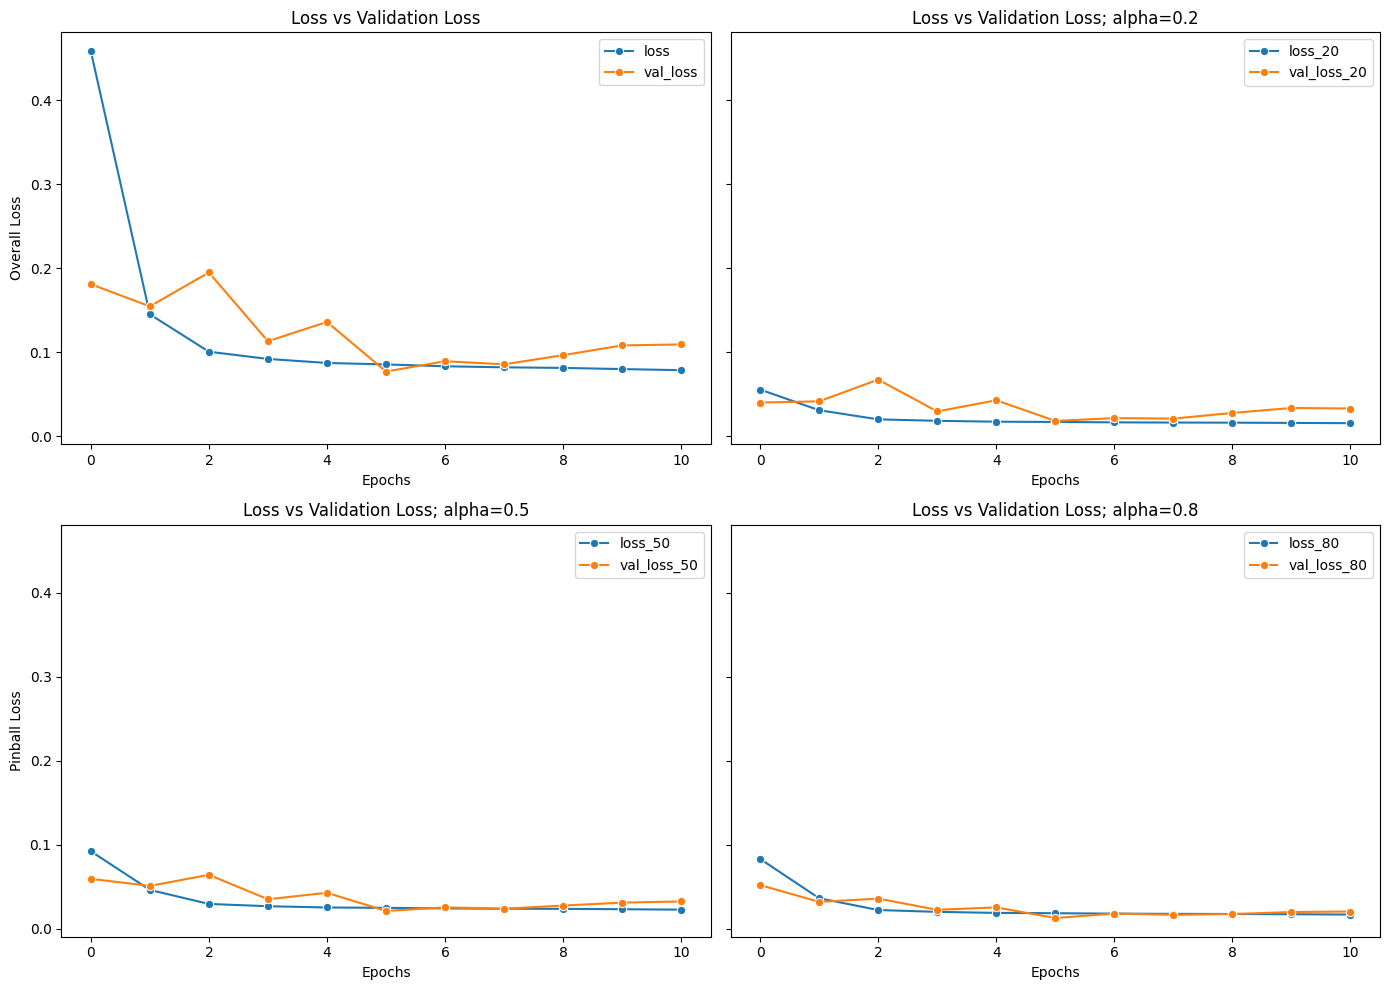

In [250]:
plot_training_metrics(history)

In [252]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional array
y_pred = pd.DataFrame({
  'pred_0.2': y_pred[0].ravel(),
  'pred_0.5': y_pred[1].ravel(),
  'pred_0.8': y_pred[2].ravel()
})

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 4s 2ms/step
RMSE: 0.043809123309271406
MSE: 0.001919239285126947
MAE: 0.028806893579454755
MAPE: 0.12134288395566327
R2 Score: 0.9952207657731981
Adjusted R2 Score: 0.9952207031464605
Pinball loss with alpha 0.2: 0.025420029924867218
Pinball loss with alpha 0.5: 0.014403446789727378
Pinball loss with alpha 0.8: 0.054085472816689004


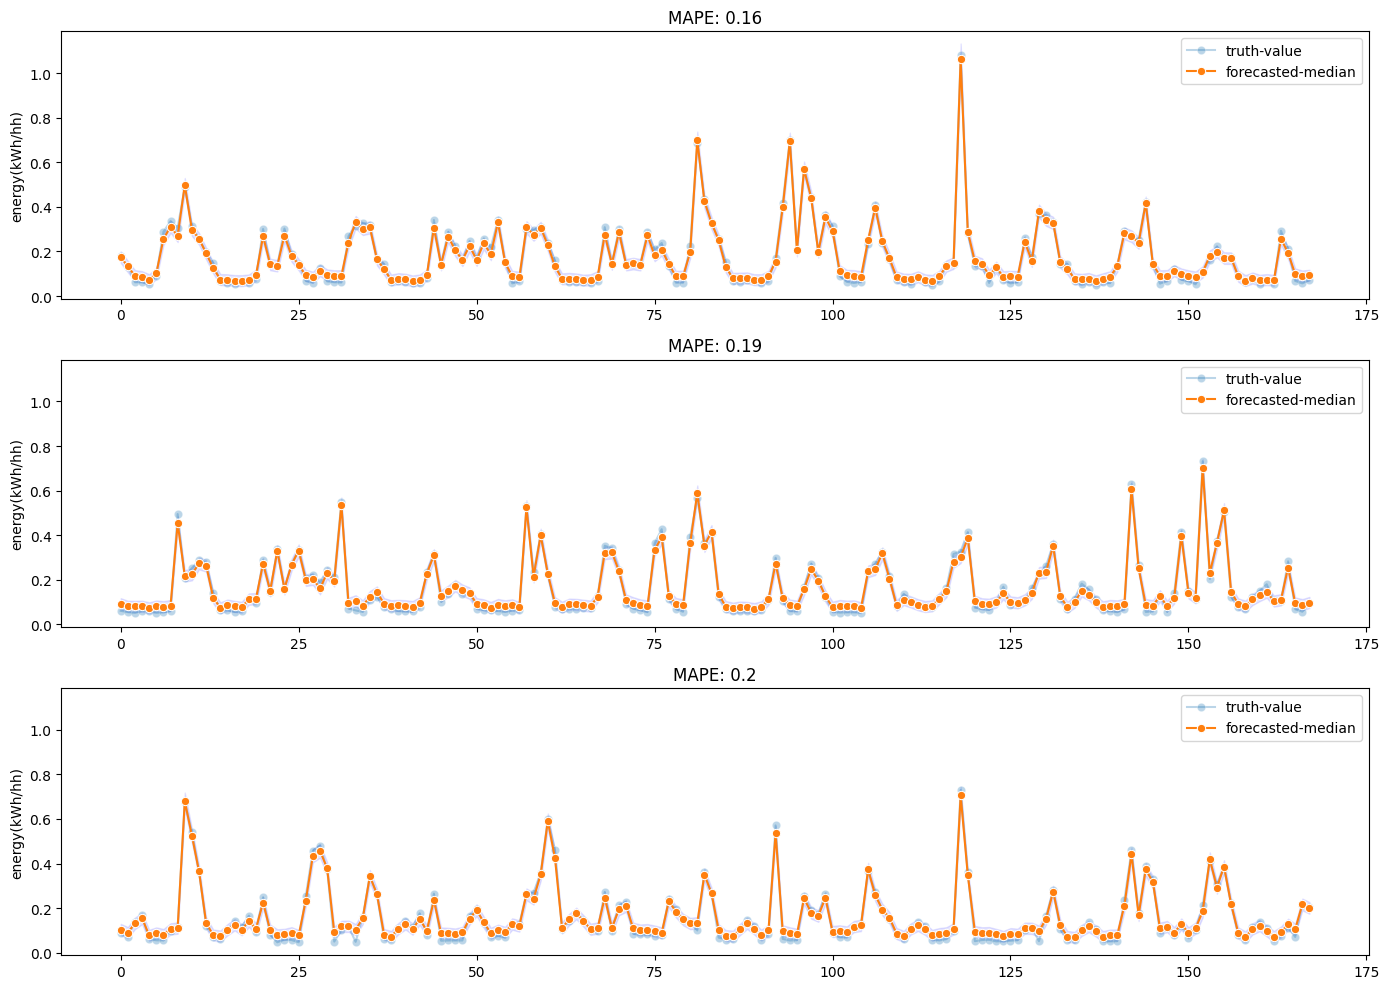

In [253]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

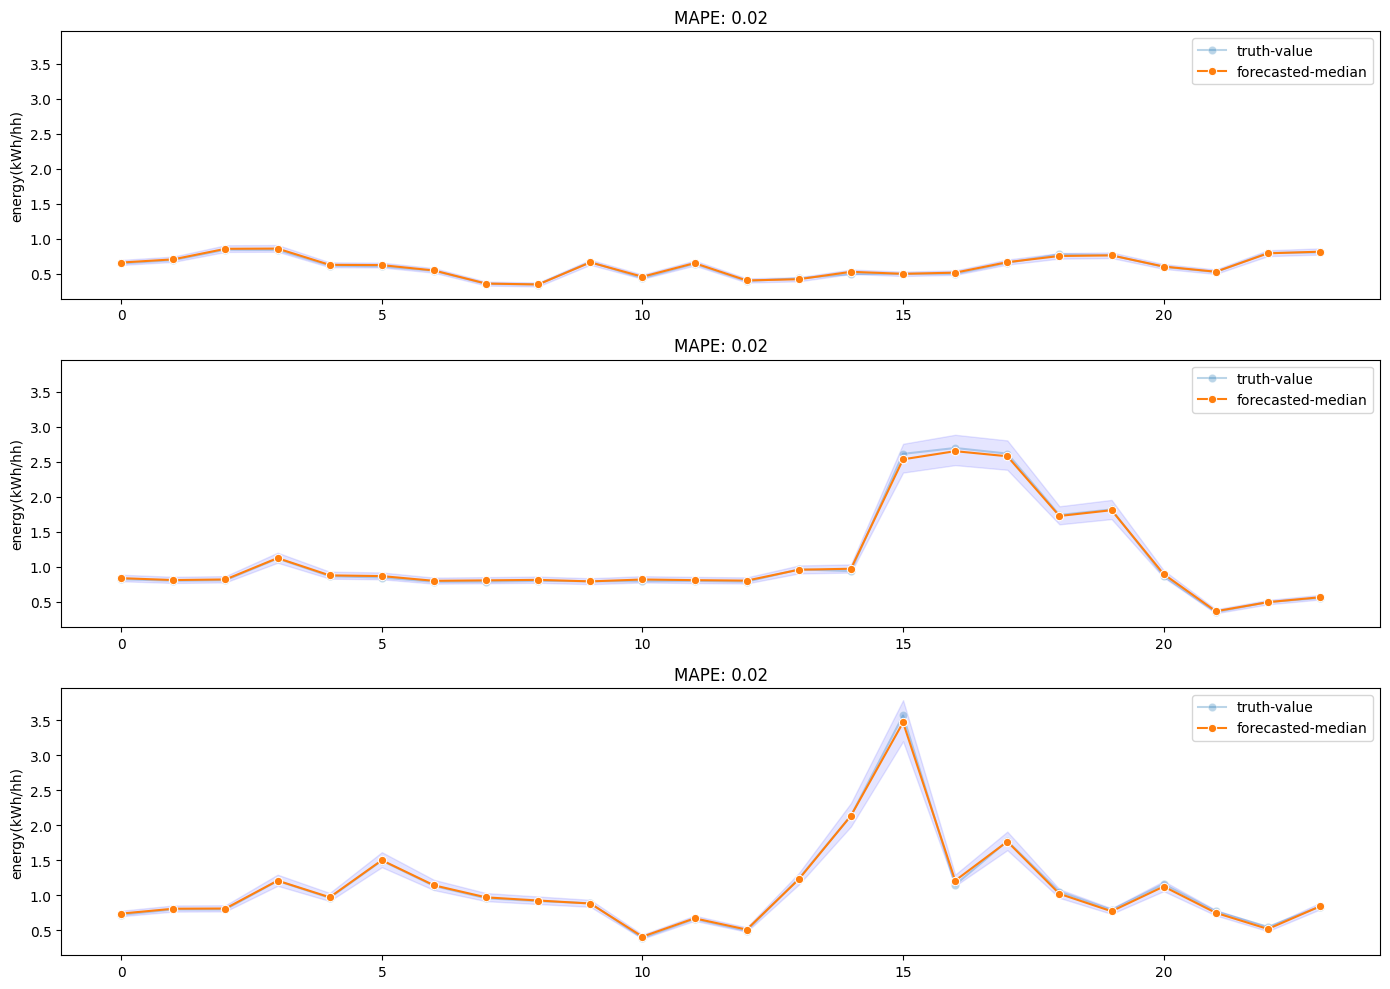

In [254]:
# Zoomed in version
plot_forecast(y_pred, y_test, 3, 24, (24 * 24))

### Quantile-GRU

In [255]:
from tensorflow.keras.layers import (
  Dense, GRU, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Create Model
input_layer = Input(shape=(1, X_train.shape[2]))
layer = GRU(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
  }
)

history = model.fit(
  X_train,
  [y_train, y_train, y_train],
  epochs=50,
  validation_split=0.2,
  batch_size=168,
  callbacks=[earlystop]
)

c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/50
3270/3270 [==============================] - 29s 8ms/step - loss: 0.4604 - output_20_loss: 0.0554 - output_50_loss: 0.0921 - output_80_loss: 0.0830 - val_loss: 0.1726 - val_output_20_loss: 0.0373 - val_output_50_loss: 0.0554 - val_output_80_loss: 0.0494
Epoch 2/50
3270/3270 [==============================] - 27s 8ms/step - loss: 0.1458 - output_20_loss: 0.0308 - output_50_loss: 0.0462 - output_80_loss: 0.0362 - val_loss: 0.1607 - val_output_20_loss: 0.0358 - val_output_50_loss: 0.0533 - val_output_80_loss: 0.0407
Epoch 3/50
3270/3270 [==============================] - 25s 8ms/step - loss: 0.0985 - output_20_loss: 0.0194 - output_50_loss: 0.0286 - output_80_loss: 0.0215 - val_loss: 0.1366 - val_output_20_loss: 0.0207 - val_output_50_loss: 0.0432 - val_output_80_loss: 0.0449
Epoch 4/50
3270/3270 [==============================] - 25s 8ms/step - loss: 0.0907 - output_20_loss: 0.0179 - output_50_loss: 0.0262 - output_80_loss: 0.0196 - val_loss: 0.1169 - val_output_20_loss: 0.018

In [256]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1, 134)]     0           []                               
                                                                                                  
 gru_3 (GRU)                    (None, 1, 100)       70800       ['input_15[0][0]']               
                                                                                                  
 dropout_14 (Dropout)           (None, 1, 100)       0           ['gru_3[0][0]']                  
                                                                                                  
 time_distributed_34 (TimeDistr  (None, 1, 168)      16968       ['dropout_14[0][0]']             
 ibuted)                                                                                   

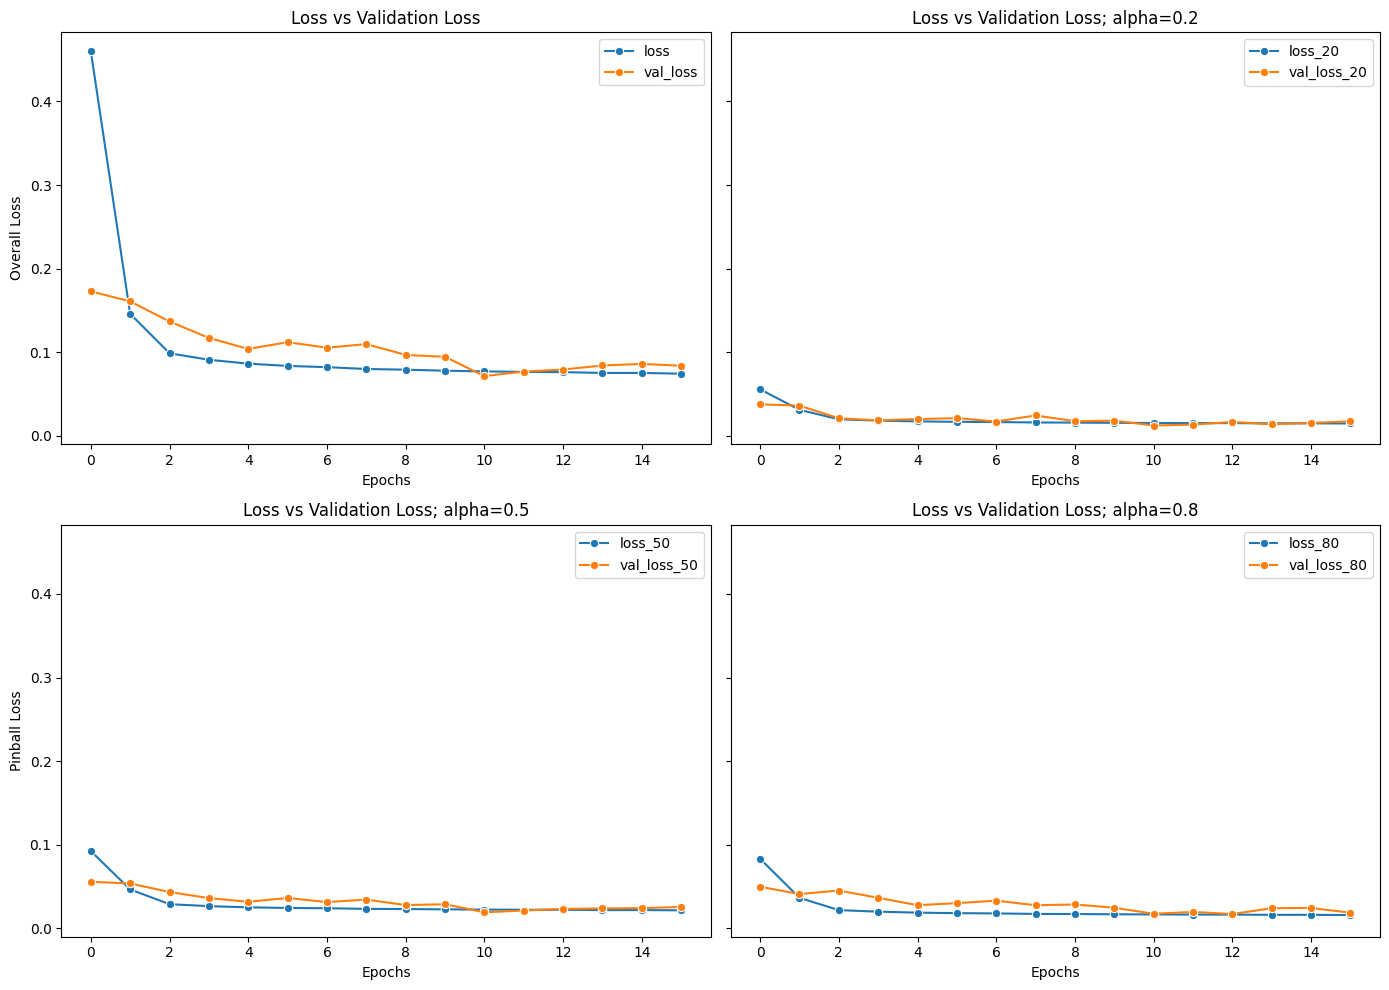

In [257]:
plot_training_metrics(history)

In [258]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional array
y_pred = pd.DataFrame({
  'pred_0.2': y_pred[0].ravel(),
  'pred_0.5': y_pred[1].ravel(),
  'pred_0.8': y_pred[2].ravel()
})

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 4s 2ms/step
RMSE: 0.05677581086266552
MSE: 0.0032234926991131676
MAE: 0.04863728140230415
MAPE: 0.18440906623699913
R2 Score: 0.9918910412716787
Adjusted R2 Score: 0.9918909350124735
Pinball loss with alpha 0.2: 0.02347800853494498
Pinball loss with alpha 0.5: 0.024318640701152076
Pinball loss with alpha 0.8: 0.08221063385214673


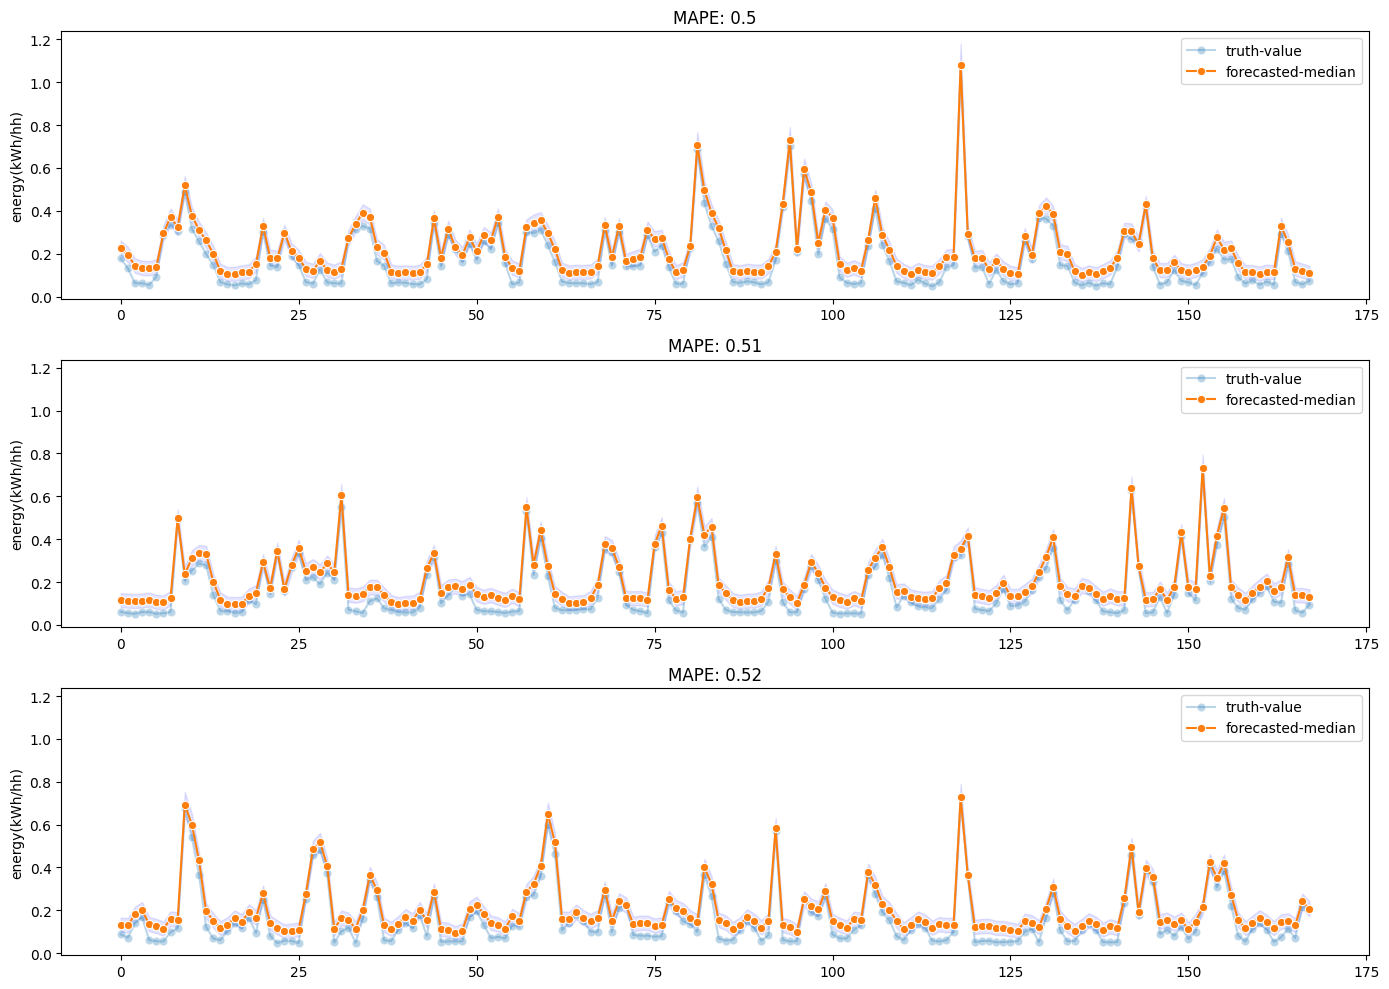

In [260]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

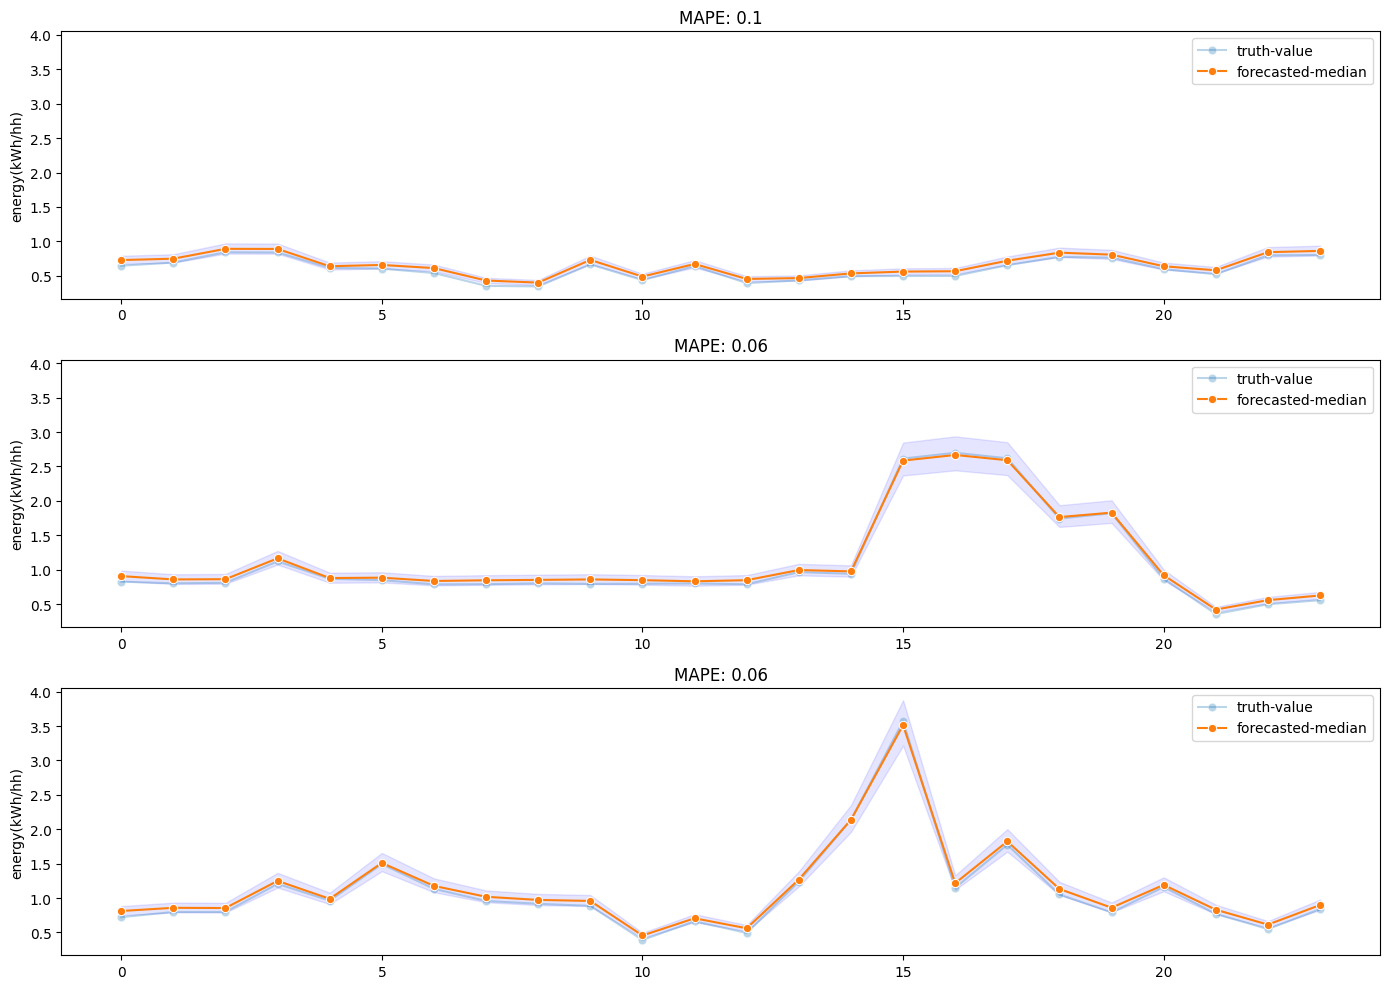

In [261]:
# Zoomed in version
plot_forecast(y_pred, y_test, 3, 24, (24 * 24))

# Hyperparameter Tuning

### Quantile-XGBoost

In [264]:
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
from sklearn.metrics import (
  mean_absolute_percentage_error, 
  mean_absolute_error, 
  mean_squared_error, 
  r2_score,
  mean_pinball_loss
)

# reshape back to the original shape for XGBoost
ml_train = X_train.reshape(X_train.shape[0], X_train.shape[2]) 
ml_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

param_grid = {
  'max_depth': [8, 9],
  'n_estimators': [500, 750, 1000],
  'learning_rate': [0.001, 0.0001, 0.003, 0.0003],
  'reg_alpha': [0.5, 0.7]
}
param_grid = ParameterGrid(param_grid)
alphas = [0.2, 0.5, 0.8]

grid_results = { 'params_used': [], 'pinball_loss_20': [], 'pinball_loss_50': [], 'pinball_loss_80': [], 'mape': [], 'mse': [], 'mae': [], 'rmse': [], 'r2': [], 'adjusted_r2': [] }

model_count = 0
for hyperparameters in param_grid:
  xgb_model = XGBRegressor(objective='reg:quantileerror', random_state=42, n_jobs=5, quantile_alpha=alphas, **hyperparameters) # uses 5 CPU cores
  xgb_model.fit(ml_train, y_train)

  # make predictions and construct the dataframe
  y_pred = xgb_model.predict(ml_test)
  y_pred = pd.DataFrame(y_pred, columns=['pred_0.2', 'pred_0.5', 'pred_0.8'])
  
  # point metrics
  mape = mean_absolute_percentage_error(y_pred['pred_0.5'], y_test)
  mae = mean_absolute_error(y_pred['pred_0.5'], y_test)
  mse = mean_squared_error(y_pred['pred_0.5'], y_test)
  rmse = mean_squared_error(y_pred['pred_0.5'], y_test, squared=False)
  r2 = r2_score(y_pred['pred_0.5'], y_test)
  adj_r2 = adjusted_r2(y_pred['pred_0.5'], y_test)

  # quantile loss
  loss_20 = mean_pinball_loss(y_pred['pred_0.2'], y_test, alpha=0.2)
  loss_50 = mean_pinball_loss(y_pred['pred_0.5'], y_test, alpha=0.5)
  loss_80 = mean_pinball_loss(y_pred['pred_0.8'], y_test, alpha=0.8)

  # store the results
  grid_results['params_used'].append(hyperparameters)
  grid_results['mape'].append(mape)
  grid_results['mse'].append(mse)
  grid_results['rmse'].append(rmse)
  grid_results['mae'].append(mae)
  grid_results['r2'].append(r2)
  grid_results['adjusted_r2'].append(adj_r2)
  grid_results['pinball_loss_20'].append(loss_20)
  grid_results['pinball_loss_50'].append(loss_50)
  grid_results['pinball_loss_80'].append(loss_80)

  # for progress
  model_count += 1
  print(f"Training completed for Model {model_count}...")

grid_results = pd.DataFrame(grid_results)

Training completed for Model 1...
Training completed for Model 2...
Training completed for Model 3...
Training completed for Model 4...
Training completed for Model 5...
Training completed for Model 6...
Training completed for Model 7...
Training completed for Model 8...
Training completed for Model 9...
Training completed for Model 10...
Training completed for Model 11...
Training completed for Model 12...
Training completed for Model 13...
Training completed for Model 14...
Training completed for Model 15...
Training completed for Model 16...
Training completed for Model 17...
Training completed for Model 18...
Training completed for Model 19...
Training completed for Model 20...
Training completed for Model 21...
Training completed for Model 22...
Training completed for Model 23...
Training completed for Model 24...
Training completed for Model 25...
Training completed for Model 26...
Training completed for Model 27...
Training completed for Model 28...
Training completed for Model 

In [274]:
# top 10 hyperparams
grid_results.sort_values(by='pinball_loss_50', ascending=True).head(10)

params_used  pinball_loss_20  \
35  {'learning_rate': 0.003, 'max_depth': 9, 'n_es...         0.158286   
34  {'learning_rate': 0.003, 'max_depth': 9, 'n_es...         0.158373   
29  {'learning_rate': 0.003, 'max_depth': 8, 'n_es...         0.164512   
28  {'learning_rate': 0.003, 'max_depth': 8, 'n_es...         0.164348   
33  {'learning_rate': 0.003, 'max_depth': 9, 'n_es...         0.167123   
32  {'learning_rate': 0.003, 'max_depth': 9, 'n_es...         0.167234   
27  {'learning_rate': 0.003, 'max_depth': 8, 'n_es...         0.172298   
26  {'learning_rate': 0.003, 'max_depth': 8, 'n_es...         0.172317   
31  {'learning_rate': 0.003, 'max_depth': 9, 'n_es...         0.180006   
30  {'learning_rate': 0.003, 'max_depth': 9, 'n_es...         0.180027   

    pinball_loss_50  pinball_loss_80      mape       mse       mae      rmse  \
35         0.066906         0.094955  0.275654  0.113464  0.133812  0.336844   
34         0.066999         0.095052  0.276015  0.113716  0.133998  0.337218   
29         0.071696         0.103186  0.296760  0.125169  0.143392  0.353792   
28         0.071725         0.103475  0.296804  0.125156  0.143449  0.353773   
33         0.075825         0.098536  0.314352  0.139853  0.151650  0.373969   
32         0.075924         0.098554  0.314846  0.139992  0.151849  0.374155   
27         0.079840         0.105427  0.333951  0.150321  0.159680  0.387712   
26         0.079925         0.105691  0.334360  0.150818  0.159850  0.388353   
31         0.091371         0.100343  0.386195  0.187062  0.182742  0.432506   
30         0.091373         0.100362  0.386376  0.186871  0.182745  0.432286   

          r2  adjusted_r2  
35  0.422769     0.422761  
34  0.420758     0.420750  
29  0.332338     0.332329  
28  0.331148     0.331140  
33  0.106365     0.106353  
32  0.104156     0.104144  
27  0.005140     0.005127  
26 -0.001735    -0.001748  
31 -0.825167    -0.825191  
30 -0.823401    -0.823425

In [272]:
best_set = grid_results.sort_values(by='pinball_loss_50', ascending=True).iloc[0]

print("Best hyperparameter:", best_set['params_used'])
print("Pinball loss; alpha=0.2: ", best_set['pinball_loss_20'])
print("Pinball loss; alpha=0.5: ", best_set['pinball_loss_50'])
print("Pinball loss; alpha=0.8: ", best_set['pinball_loss_80'])
print("R2 Score: ", best_set['r2'])
print("MAE:", best_set['mae'])
print("MSE:", best_set['mse'])
print("RMSE:", best_set['rmse'])
print("MAPE:", best_set['mape'])


Best hyperparameter: {'learning_rate': 0.003, 'max_depth': 9, 'n_estimators': 1000, 'reg_alpha': 0.7}
Pinball loss; alpha=0.2:  0.15828588764430016
Pinball loss; alpha=0.5:  0.06690596279810374
Pinball loss; alpha=0.8:  0.0949553740484048
R2 Score:  0.42276862419855876
MAE: 0.13381192559620747
MSE: 0.11346393484924026
RMSE: 0.33684408091762613
MAPE: 0.2756535608531078


In [11]:
from xgboost import XGBRegressor

alphas = [0.2, 0.5, 0.8]
best_hyperparams = {'learning_rate': 0.003, 'max_depth': 9, 'n_estimators': 1000, 'reg_alpha': 0.7}
best_xgb = XGBRegressor(objective='reg:quantileerror', random_state=42, n_jobs=5, quantile_alpha=alphas, **best_hyperparams) # uses 5 CPU cores
best_xgb.fit(ml_train, y_train)

y_pred = best_xgb.predict(ml_test)
y_pred = pd.DataFrame(y_pred, columns=['pred_0.2', 'pred_0.5', 'pred_0.8'])

evaluate_model(y_pred, y_test)


RMSE: 0.33684408091762613
MSE: 0.11346393484924026
MAE: 0.13381192559620747
MAPE: 0.2756535608531078
R2 Score: 0.42276862419855876
Adjusted R2 Score: 0.42276106020060555
Pinball loss with alpha 0.2: 0.15828588764430016
Pinball loss with alpha 0.5: 0.06690596279810374
Pinball loss with alpha 0.8: 0.0949553740484048


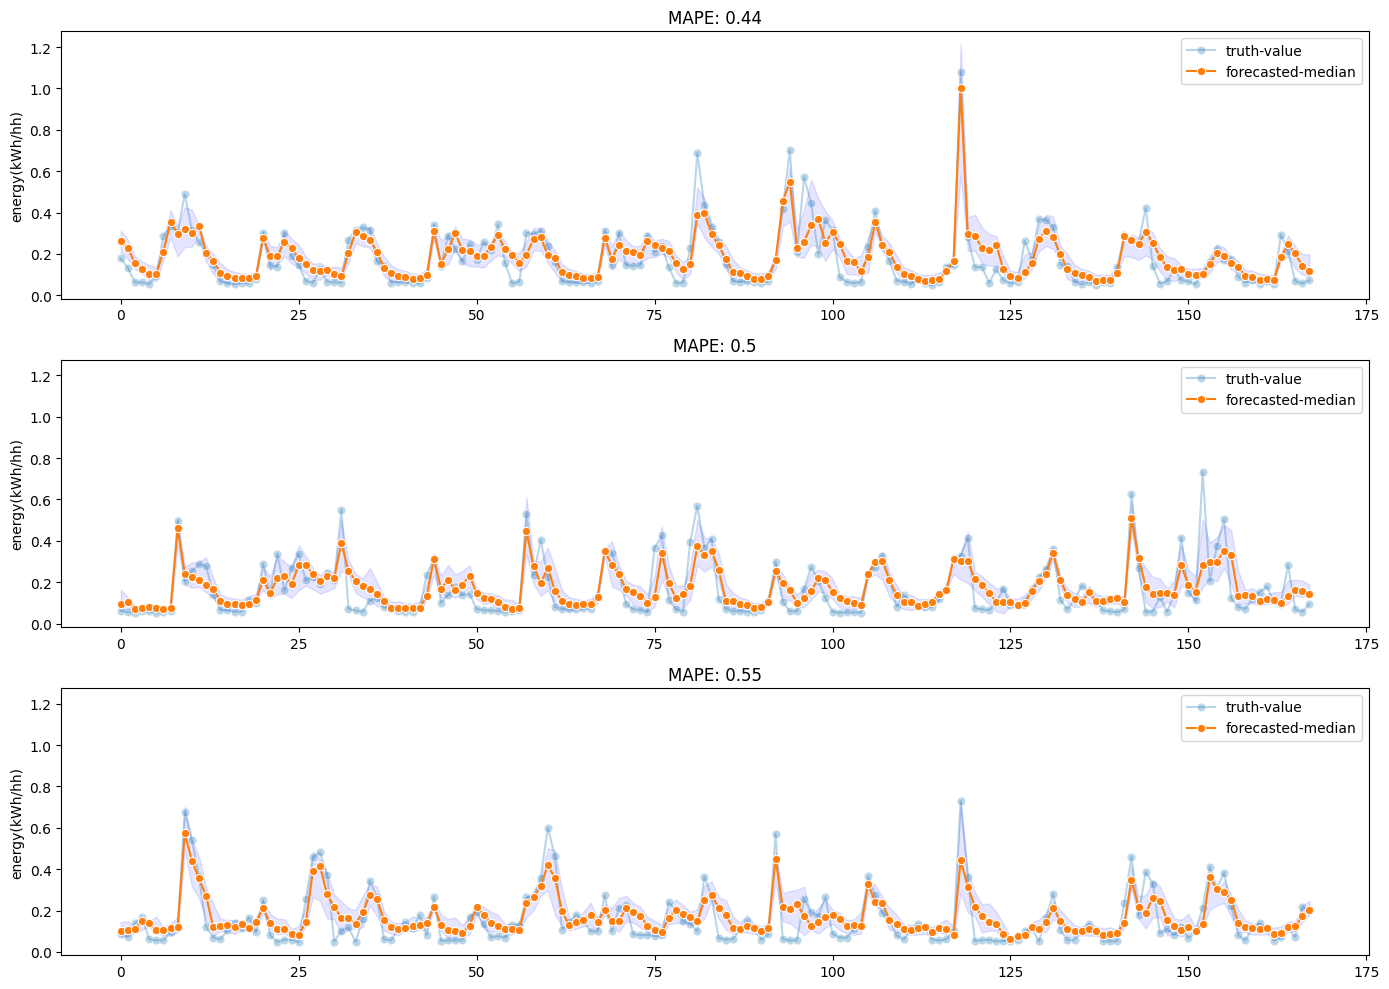

In [12]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

### Tuning Quantile-LightGBM

In [21]:
from lightgbm import LGBMRegressor
from sklearn.metrics import (
  mean_absolute_percentage_error, 
  mean_absolute_error, 
  mean_squared_error, 
  r2_score,
  mean_pinball_loss
)

class QuantileLightGBM:
  def __init__(self, alphas=[0.2, 0.5, 0.8], **keyword_args):
    self.models = {}
    self.alphas = alphas
    self.hyperparams = keyword_args

  def fit(self, X_train, y_train):
    # train respective models for each quantile
    for alpha in self.alphas:
      model = LGBMRegressor(
        random_state=42, 
        objective='quantile', 
        alpha=alpha,
        **self.hyperparams
      )
      
      # fit the model
      model.fit(X_train, y_train)
      self.models[f'model_{str(alpha)}'] = model # save the model

  def predict(self, X_test):
    y_pred = {}
    for i in range(len(self.alphas)):
      alpha = self.alphas[i]
      model = self.models[f'model_{str(alpha)}']
      y_pred[f'pred_{str(alpha)}'] = model.predict(X_test)

    return pd.DataFrame(y_pred)
  
  def evaluate(self, X_test, y_test):
      y_pred = self.predict(X_test)

      # point metrics
      mape = mean_absolute_percentage_error(y_pred['pred_0.5'], y_test)
      mae = mean_absolute_error(y_pred['pred_0.5'], y_test)
      mse = mean_squared_error(y_pred['pred_0.5'], y_test)
      rmse = mean_squared_error(y_pred['pred_0.5'], y_test, squared=False)
      r2 = r2_score(y_pred['pred_0.5'], y_test)
      adj_r2 = adjusted_r2(y_pred['pred_0.5'], y_test)

      # quantile loss
      loss_20 = mean_pinball_loss(y_pred['pred_0.2'], y_test, alpha=0.2)
      loss_50 = mean_pinball_loss(y_pred['pred_0.5'], y_test, alpha=0.5)
      loss_80 = mean_pinball_loss(y_pred['pred_0.8'], y_test, alpha=0.8)

      return {
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'adjusted_r2': adj_r2,
        'pinball_loss_20': loss_20,
        'pinball_loss_50': loss_50,
        'pinball_loss_80': loss_80
      }

In [35]:
from sklearn.model_selection import ParameterGrid

# reshape back to the original shape for LightGBM
ml_train = X_train.reshape(X_train.shape[0], X_train.shape[2]) 
ml_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

param_grid = {
  'max_depth': [8, 9, 10],
  'n_estimators': [500, 750, 1000],
  'learning_rate': [0.01, 0.001, 0.0001, 0.03, 0.003, 0.0003],
  'reg_alpha': [0.5, 0.7]
}
param_grid = ParameterGrid(param_grid)
alphas = [0.2, 0.5, 0.8]

grid_results = { 'params_used': [], 'pinball_loss_20': [], 'pinball_loss_50': [], 'pinball_loss_80': [], 'mape': [], 'mse': [], 'mae': [], 'rmse': [], 'r2': [], 'adjusted_r2': [] }

model_count = 0
for hyperparameters in param_grid:
  lgbm_model = QuantileLightGBM(alphas=alphas, **hyperparameters) # uses 5 CPU cores
  lgbm_model.fit(ml_train, y_train)
  metrics = lgbm_model.evaluate(ml_test, y_test)

  # store the results
  grid_results['params_used'].append(hyperparameters)
  grid_results['mape'].append(metrics['mape'])
  grid_results['mse'].append(metrics['mse'])
  grid_results['rmse'].append(metrics['rmse'])
  grid_results['mae'].append(metrics['mae'])
  grid_results['r2'].append(metrics['r2'])
  grid_results['adjusted_r2'].append(metrics['adjusted_r2'])
  grid_results['pinball_loss_20'].append(metrics['pinball_loss_20'])
  grid_results['pinball_loss_50'].append(metrics['pinball_loss_50'])
  grid_results['pinball_loss_80'].append(metrics['pinball_loss_80'])

  # for progress
  model_count += 1
  print(f"Training completed for Model {model_count}...")

grid_results = pd.DataFrame(grid_results)

Training completed for Model 1...
Training completed for Model 2...
Training completed for Model 3...
Training completed for Model 4...
Training completed for Model 5...
Training completed for Model 6...
Training completed for Model 7...
Training completed for Model 8...
Training completed for Model 9...
Training completed for Model 10...
Training completed for Model 11...
Training completed for Model 12...
Training completed for Model 13...
Training completed for Model 14...
Training completed for Model 15...
Training completed for Model 16...
Training completed for Model 17...
Training completed for Model 18...
Training completed for Model 19...
Training completed for Model 20...
Training completed for Model 21...
Training completed for Model 22...
Training completed for Model 23...
Training completed for Model 24...
Training completed for Model 25...
Training completed for Model 26...
Training completed for Model 27...
Training completed for Model 28...
Training completed for Model 

In [36]:
grid_results.to_parquet('grid_results_quantile_lightgbm.parquet', index=False)

In [37]:
grid_results.sort_values(by='pinball_loss_50', ascending=True).head(10)

params_used  pinball_loss_20  \
71  {'learning_rate': 0.03, 'max_depth': 10, 'n_es...         0.121395   
70  {'learning_rate': 0.03, 'max_depth': 10, 'n_es...         0.121086   
64  {'learning_rate': 0.03, 'max_depth': 9, 'n_est...         0.121562   
65  {'learning_rate': 0.03, 'max_depth': 9, 'n_est...         0.122280   
59  {'learning_rate': 0.03, 'max_depth': 8, 'n_est...         0.123864   
58  {'learning_rate': 0.03, 'max_depth': 8, 'n_est...         0.123740   
69  {'learning_rate': 0.03, 'max_depth': 10, 'n_es...         0.131813   
68  {'learning_rate': 0.03, 'max_depth': 10, 'n_es...         0.131824   
62  {'learning_rate': 0.03, 'max_depth': 9, 'n_est...         0.131337   
63  {'learning_rate': 0.03, 'max_depth': 9, 'n_est...         0.132227   

    pinball_loss_50  pinball_loss_80      mape       mse       mae      rmse  \
71         0.047032         0.078470  0.199688  0.067773  0.094064  0.260333   
70         0.047273         0.078966  0.200161  0.068476  0.094545  0.261680   
64         0.047613         0.078491  0.202369  0.068542  0.095227  0.261804   
65         0.047614         0.078808  0.207855  0.068536  0.095227  0.261793   
59         0.047901         0.079383  0.205576  0.068954  0.095801  0.262591   
58         0.048299         0.078853  0.205165  0.070329  0.096598  0.265195   
69         0.052408         0.085531  0.218277  0.081998  0.104815  0.286352   
68         0.052442         0.085645  0.219323  0.081807  0.104884  0.286019   
62         0.052710         0.085627  0.223959  0.082340  0.105420  0.286949   
63         0.052731         0.085465  0.218541  0.082443  0.105462  0.287130   

          r2  adjusted_r2  
71  0.757883     0.757880  
70  0.754821     0.754818  
64  0.753658     0.753654  
65  0.753205     0.753201  
59  0.750416     0.750413  
58  0.743926     0.743922  
69  0.684502     0.684498  
68  0.685722     0.685718  
62  0.682876     0.682871  
63  0.682555     0.682551

In [40]:
best_set = grid_results.sort_values(by='pinball_loss_50', ascending=True).iloc[0]

print("Best hyperparameter:", best_set['params_used'])
print("Pinball loss; alpha=0.2: ", best_set['pinball_loss_20'])
print("Pinball loss; alpha=0.5: ", best_set['pinball_loss_50'])
print("Pinball loss; alpha=0.8: ", best_set['pinball_loss_80'])
print("R2 Score: ", best_set['r2'])
print("MAE:", best_set['mae'])
print("MSE:", best_set['mse'])
print("RMSE:", best_set['rmse'])
print("MAPE:", best_set['mape'])


Best hyperparameter: {'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 1000, 'reg_alpha': 0.7}
Pinball loss; alpha=0.2:  0.12139488373379846
Pinball loss; alpha=0.5:  0.047032159818826975
Pinball loss; alpha=0.8:  0.07847047966867078
R2 Score:  0.7578827417780442
MAE: 0.09406431963765395
MSE: 0.06777313528902151
RMSE: 0.2603327395642383
MAPE: 0.1996880147078355


In [41]:
hyperparameters = {'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 1000, 'reg_alpha': 0.7}

lgbm_model = QuantileLightGBM(alphas=alphas, **hyperparameters)
lgbm_model.fit(ml_train, y_train)

metrics = lgbm_model.evaluate(ml_test, y_test)
metrics

{'mape': 0.1996880147078355,
 'mse': 0.06777313528902151,
 'rmse': 0.2603327395642383,
 'mae': 0.09406431963765395,
 'r2': 0.7578827417780442,
 'adjusted_r2': 0.7578795690911072,
 'pinball_loss_20': 0.12139488373379846,
 'pinball_loss_50': 0.047032159818826975,
 'pinball_loss_80': 0.07847047966867078}

In [42]:
y_pred = lgbm_model.predict(ml_test)

In [45]:
evaluate_model(y_pred, y_test)

RMSE: 0.2603327395642383
MSE: 0.06777313528902151
MAE: 0.09406431963765395
MAPE: 0.1996880147078355
R2 Score: 0.7578827417780442
Adjusted R2 Score: 0.7578795690911072
Pinball loss with alpha 0.2: 0.12139488373379846
Pinball loss with alpha 0.5: 0.047032159818826975
Pinball loss with alpha 0.8: 0.07847047966867078


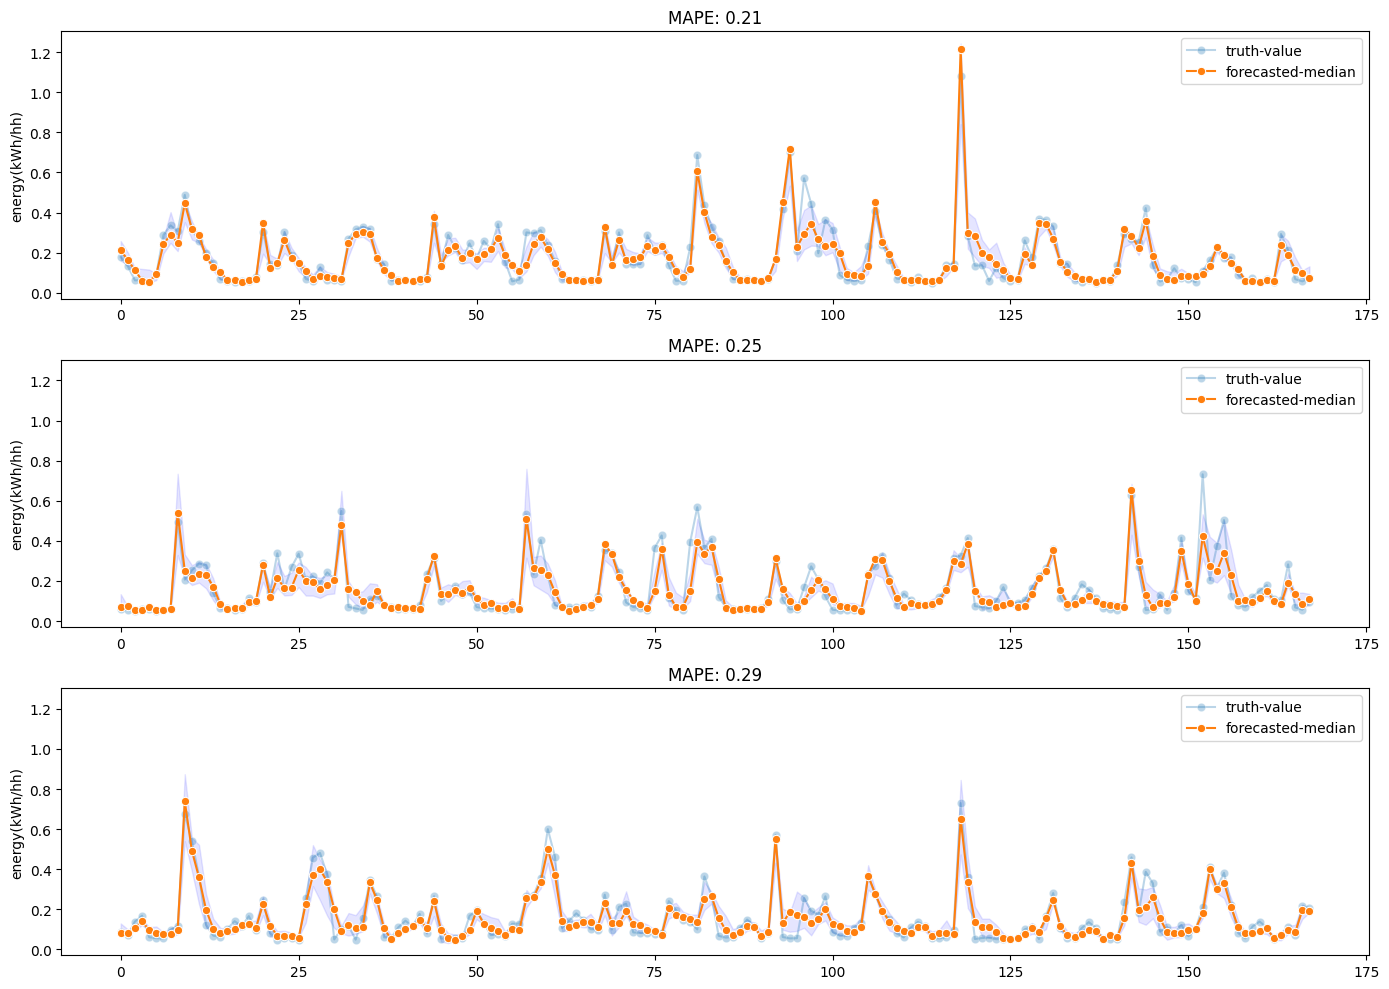

In [44]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

### Tuning Quantile-LSTM

1. Add 1 LSTM Layer
2. Add 2 LSTM Layer
3. Add 1 Dense Layer

In [70]:
from tensorflow.keras.layers import (
  Dense, LSTM, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Create Model
input_layer = Input(shape=(1, X_train.shape[2]))
layer = LSTM(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
  }
)

history = model.fit(
  X_train,
  [y_train, y_train, y_train],
  epochs=50,
  validation_data=(X_test, [y_test, y_test, y_test]),
  batch_size=168,
  callbacks=[earlystop]
)

Epoch 1/50
4087/4087 [==============================] - 36s 9ms/step - loss: 0.3906 - output_20_loss: 0.0503 - output_50_loss: 0.0820 - output_80_loss: 0.0723 - val_loss: 0.1239 - val_output_20_loss: 0.0229 - val_output_50_loss: 0.0388 - val_output_80_loss: 0.0333
Epoch 2/50
4087/4087 [==============================] - 34s 8ms/step - loss: 0.1108 - output_20_loss: 0.0233 - output_50_loss: 0.0346 - output_80_loss: 0.0260 - val_loss: 0.0705 - val_output_20_loss: 0.0134 - val_output_50_loss: 0.0160 - val_output_80_loss: 0.0150
Epoch 3/50
4087/4087 [==============================] - 34s 8ms/step - loss: 0.0940 - output_20_loss: 0.0194 - output_50_loss: 0.0285 - output_80_loss: 0.0211 - val_loss: 0.0621 - val_output_20_loss: 0.0108 - val_output_50_loss: 0.0124 - val_output_80_loss: 0.0144
Epoch 4/50
4087/4087 [==============================] - 34s 8ms/step - loss: 0.0894 - output_20_loss: 0.0183 - output_50_loss: 0.0269 - output_80_loss: 0.0199 - val_loss: 0.0849 - val_output_20_loss: 0.020

In [71]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1, 134)]     0           []                               
                                                                                                  
 lstm_10 (LSTM)                 (None, 1, 100)       94000       ['input_6[0][0]']                
                                                                                                  
 dropout_5 (Dropout)            (None, 1, 100)       0           ['lstm_10[0][0]']                
                                                                                                  
 time_distributed_10 (TimeDistr  (None, 1, 168)      16968       ['dropout_5[0][0]']              
 ibuted)                                                                                    

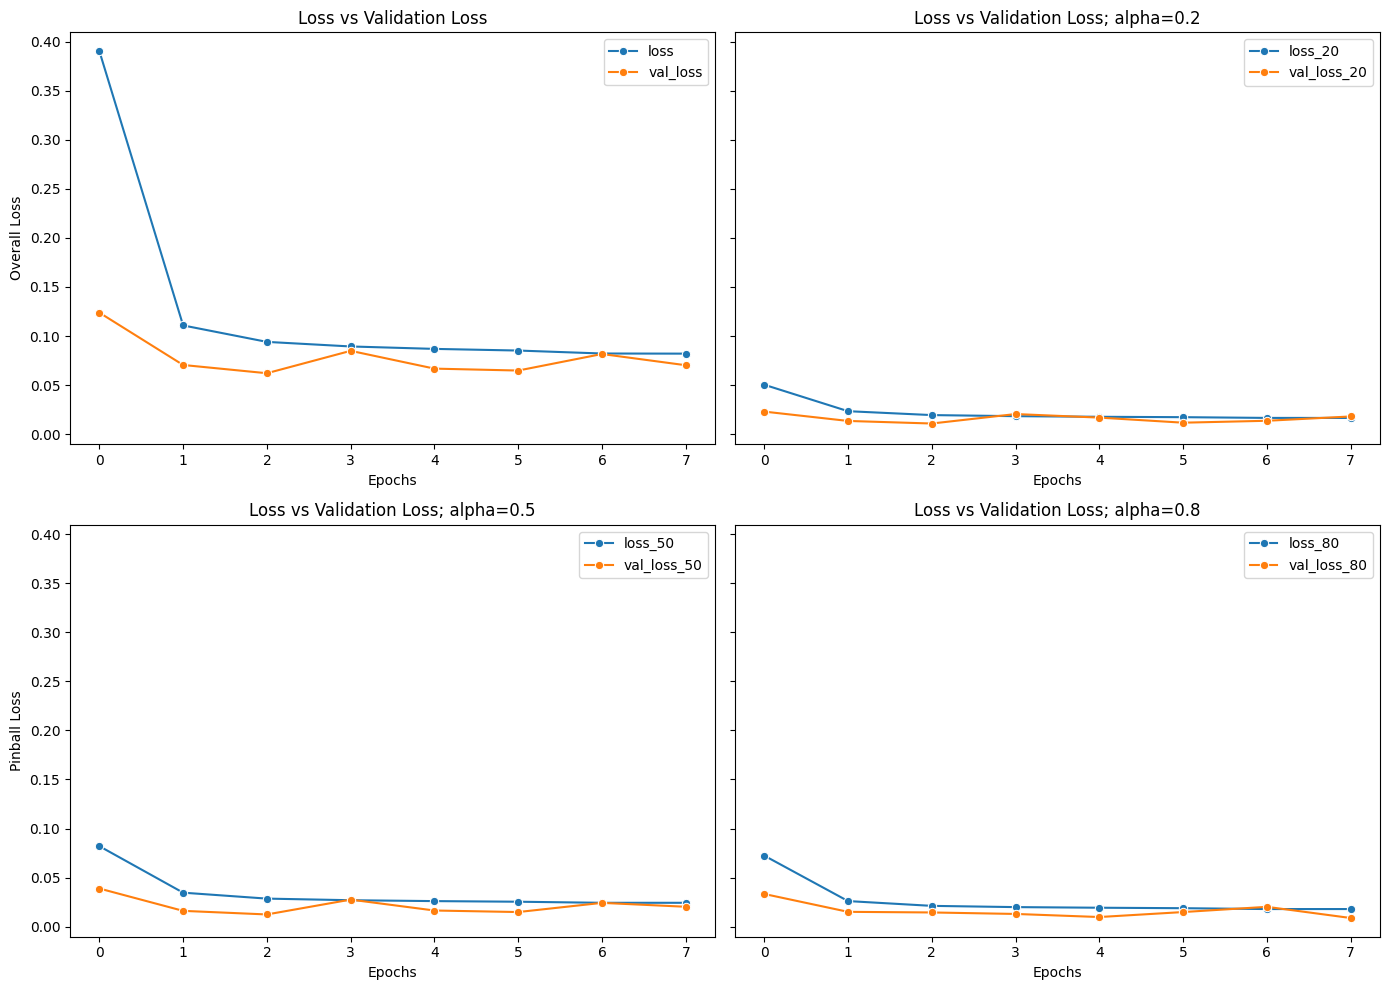

In [72]:
plot_training_metrics(history)

In [73]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional array
y_pred = pd.DataFrame({
  'pred_0.2': y_pred[0].ravel(),
  'pred_0.5': y_pred[1].ravel(),
  'pred_0.8': y_pred[2].ravel()
})

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 5s 2ms/step
RMSE: 0.06139086121531713
MSE: 0.0037688378407583294
MAE: 0.04042047364241525
MAPE: 0.1487795903596944
R2 Score: 0.989676230529576
Adjusted R2 Score: 0.9896760952476519
Pinball loss with alpha 0.2: 0.07099219762616546
Pinball loss with alpha 0.5: 0.020210236821207626
Pinball loss with alpha 0.8: 0.025403173560873567


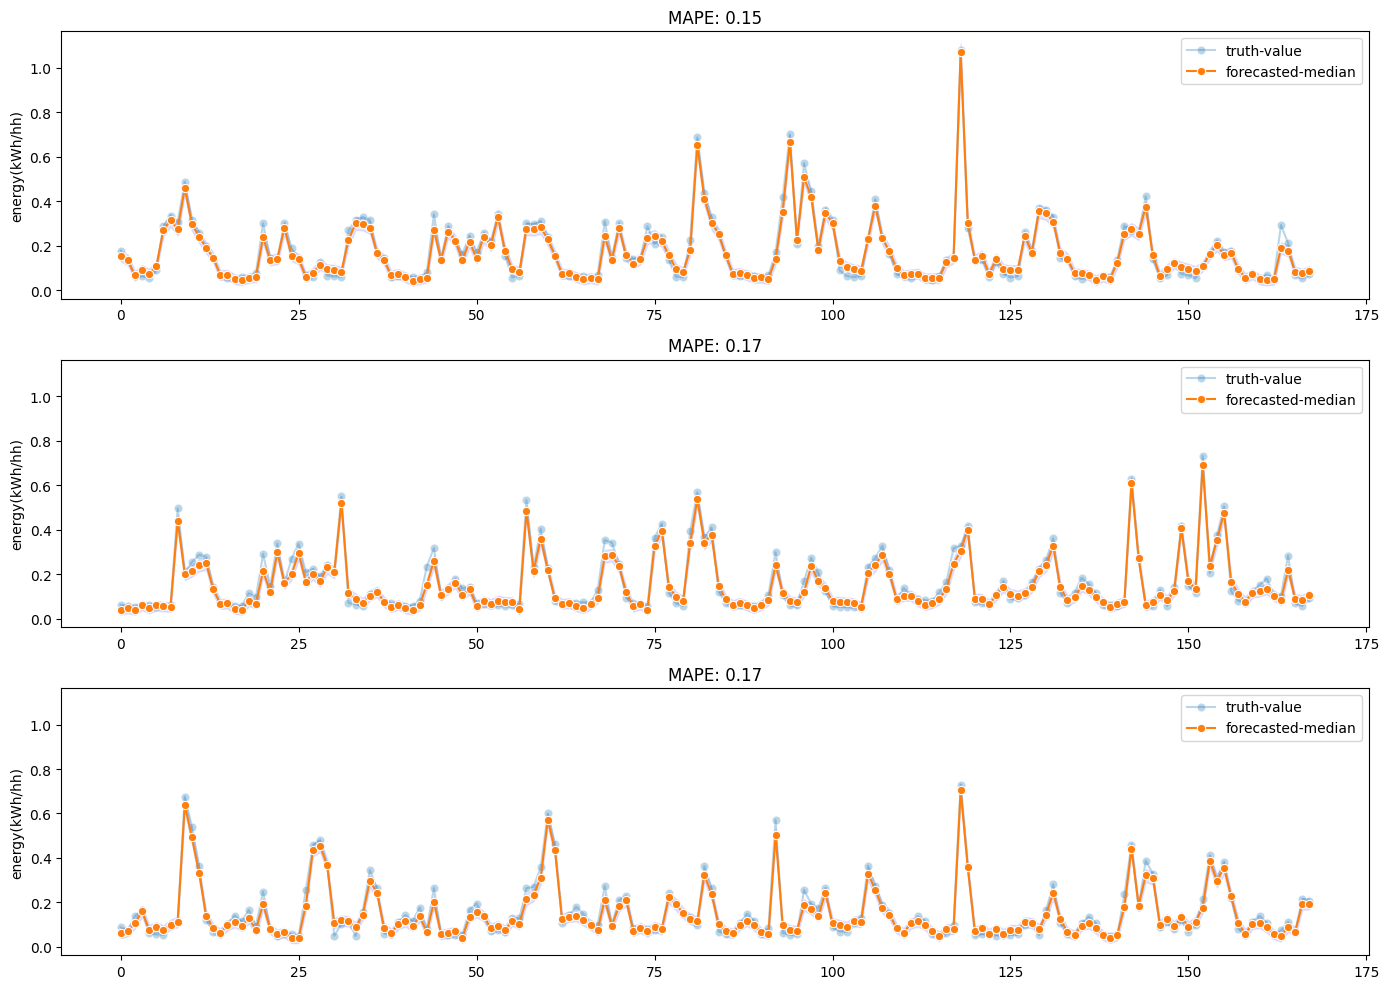

In [68]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

In [79]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, LSTM,
    TimeDistributed, Dropout, Input
)
import keras_tuner as kt

class LSTMTunedModel(kt.HyperModel):

    def build(self, hyperparameters):
        # for reproducibility
        tf.random.set_seed(42)
        tf.keras.utils.set_random_seed(42)
        tf.config.experimental.enable_op_determinism()

        hp_lstm_units = hyperparameters.Int("lstm_units", min_value=100, max_value=300, step=100)
        hp_dropout_rate = hyperparameters.Choice("dropout", values=[0.2, 0.3, 0.4, 0.5])
        hp_learning_rate = hyperparameters.Choice("learning_rate", values=[0.001, 0.0001, 0.003, 0.0003])

        # input 
        input_layer = Input(shape=(1, X_train.shape[2]))
        layer = LSTM(hp_lstm_units, return_sequences=True)(input_layer)
        layer = Dropout(hp_dropout_rate)(layer)

        # full connected layer
        layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
        layer = TimeDistributed(Dense(64, activation='relu'))(layer)

        # output
        output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
        output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
        output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
        model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss={
                "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
                "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
                "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
            }
        )

        return model

    def fit(self, hyperparameters, model, *args, **kwargs):
        # for reproducibility
        tf.random.set_seed(42)
        tf.keras.utils.set_random_seed(42)
        tf.config.experimental.enable_op_determinism()
        
        return model.fit(
            *args,
            batch_size=hyperparameters.Choice("batch_size", [168, 336, 504]),
            **kwargs,
        )

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner = kt.Hyperband(
  LSTMTunedModel(),
  objective='val_loss',
  seed=42,
  max_epochs=50,
  factor=3,
  directory='quantile_lstm_tuned', # path to save the model tuning data
  project_name="tune_quantile_lstm",
  overwrite=False
)
tuner.search(X_train, [y_train, y_train, y_train], epochs=50, validation_data=(X_test, [y_test, y_test, y_test]), callbacks=[earlystop])

Trial 90 Complete [00h 18m 14s]
val_loss: 0.024926405400037766

Best val_loss So Far: 0.023923389613628387
Total elapsed time: 03h 46m 57s


In [80]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'lstm_units': 300,
 'dropout': 0.2,
 'learning_rate': 0.0001,
 'batch_size': 168,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [81]:
# input 
input_layer = Input(shape=(1, X_train.shape[2]))

# stacked lstm
layer = LSTM(300, return_sequences=True)(input_layer)
layer = Dropout(0.2)(layer)

# full connected layer
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)

# output
output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
        "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
        "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
    }
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=168,
    callbacks=[earlystop]
)

Epoch 1/50
4087/4087 [==============================] - 36s 8ms/step - loss: 2.9423 - output_20_loss: 0.0596 - output_50_loss: 0.1045 - output_80_loss: 0.1018 - val_loss: 0.2812 - val_output_20_loss: 0.0634 - val_output_50_loss: 0.1026 - val_output_80_loss: 0.0921
Epoch 2/50
4087/4087 [==============================] - 34s 8ms/step - loss: 0.2387 - output_20_loss: 0.0529 - output_50_loss: 0.0864 - output_80_loss: 0.0781 - val_loss: 0.2495 - val_output_20_loss: 0.0589 - val_output_50_loss: 0.0912 - val_output_80_loss: 0.0802
Epoch 3/50
4087/4087 [==============================] - 33s 8ms/step - loss: 0.2209 - output_20_loss: 0.0505 - output_50_loss: 0.0801 - output_80_loss: 0.0713 - val_loss: 0.2327 - val_output_20_loss: 0.0561 - val_output_50_loss: 0.0849 - val_output_80_loss: 0.0734
Epoch 4/50
4087/4087 [==============================] - 33s 8ms/step - loss: 0.2069 - output_20_loss: 0.0483 - output_50_loss: 0.0748 - output_80_loss: 0.0654 - val_loss: 0.2140 - val_output_20_loss: 0.052

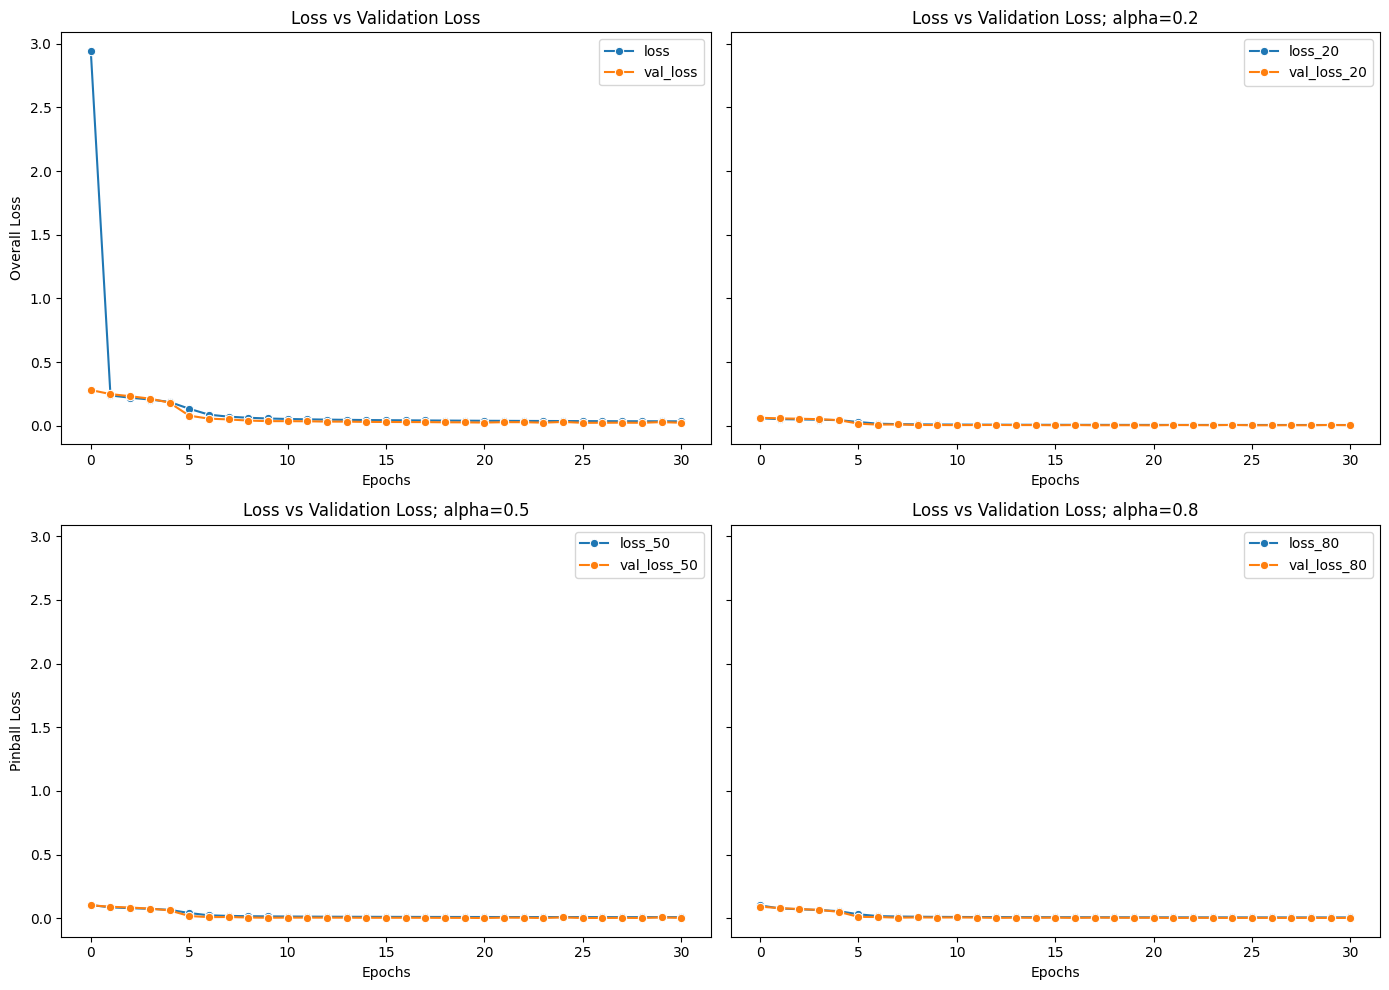

In [82]:
plot_training_metrics(history)

In [83]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional array
y_pred = pd.DataFrame({
  'pred_0.2': y_pred[0].ravel(),
  'pred_0.5': y_pred[1].ravel(),
  'pred_0.8': y_pred[2].ravel()
})

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 4s 2ms/step
RMSE: 0.015480914777196252
MSE: 0.00023965872233881326
MAE: 0.0075637970433582394
MAPE: 0.03562829154035935
R2 Score: 0.99940041826871
Adjusted R2 Score: 0.9994004104118346
Pinball loss with alpha 0.2: 0.019668391027649324
Pinball loss with alpha 0.5: 0.0037818985216791197
Pinball loss with alpha 0.8: 0.01305718849321842


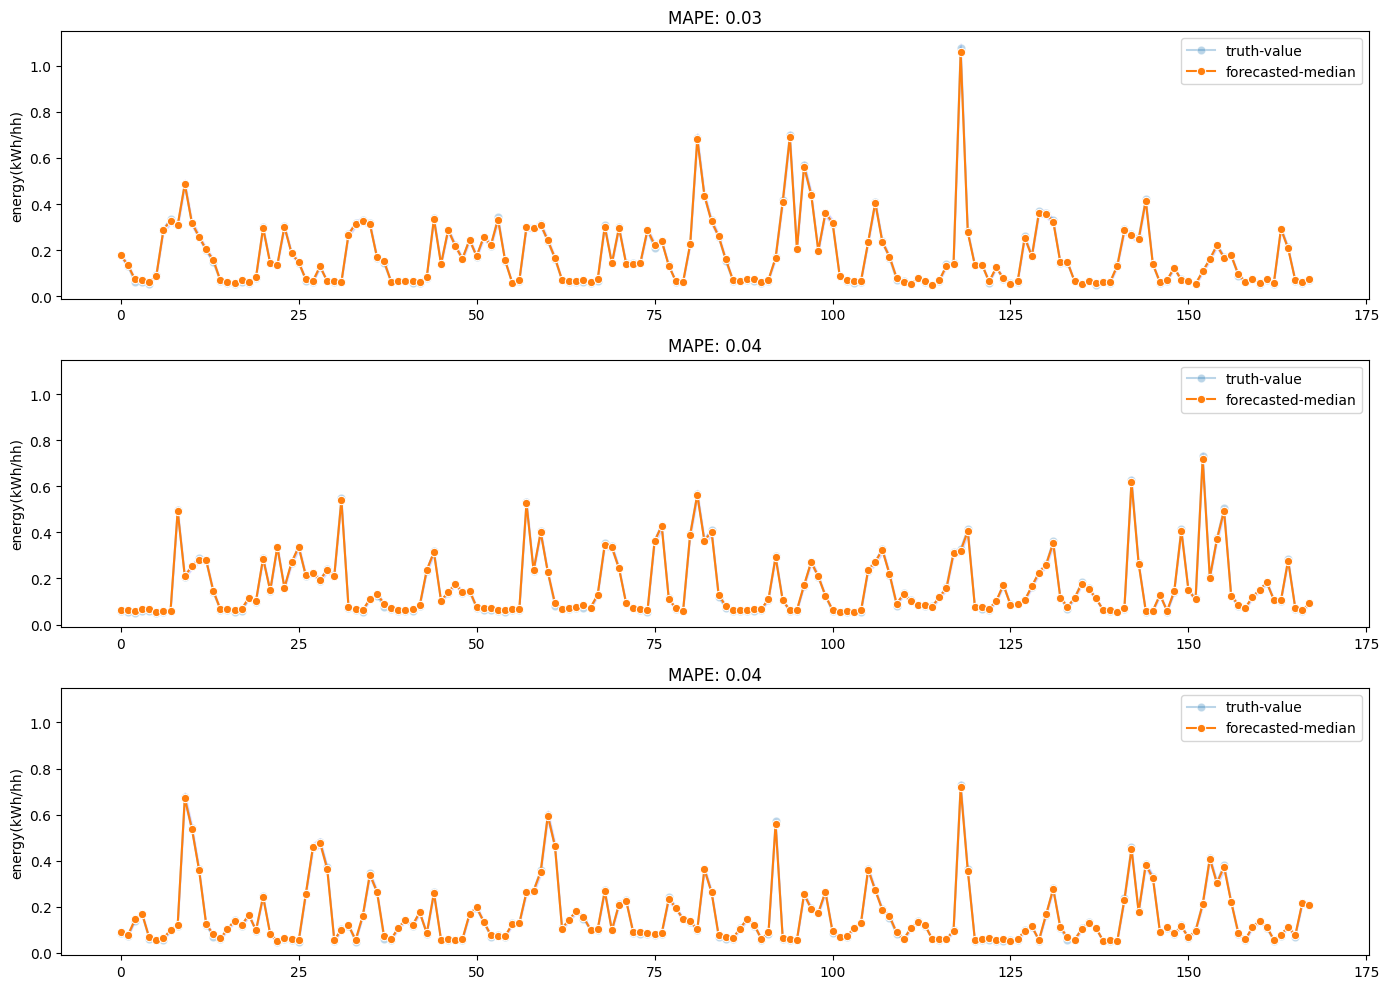

In [84]:
plot_forecast(y_pred, y_test, 3, 168, skip=(168*24))

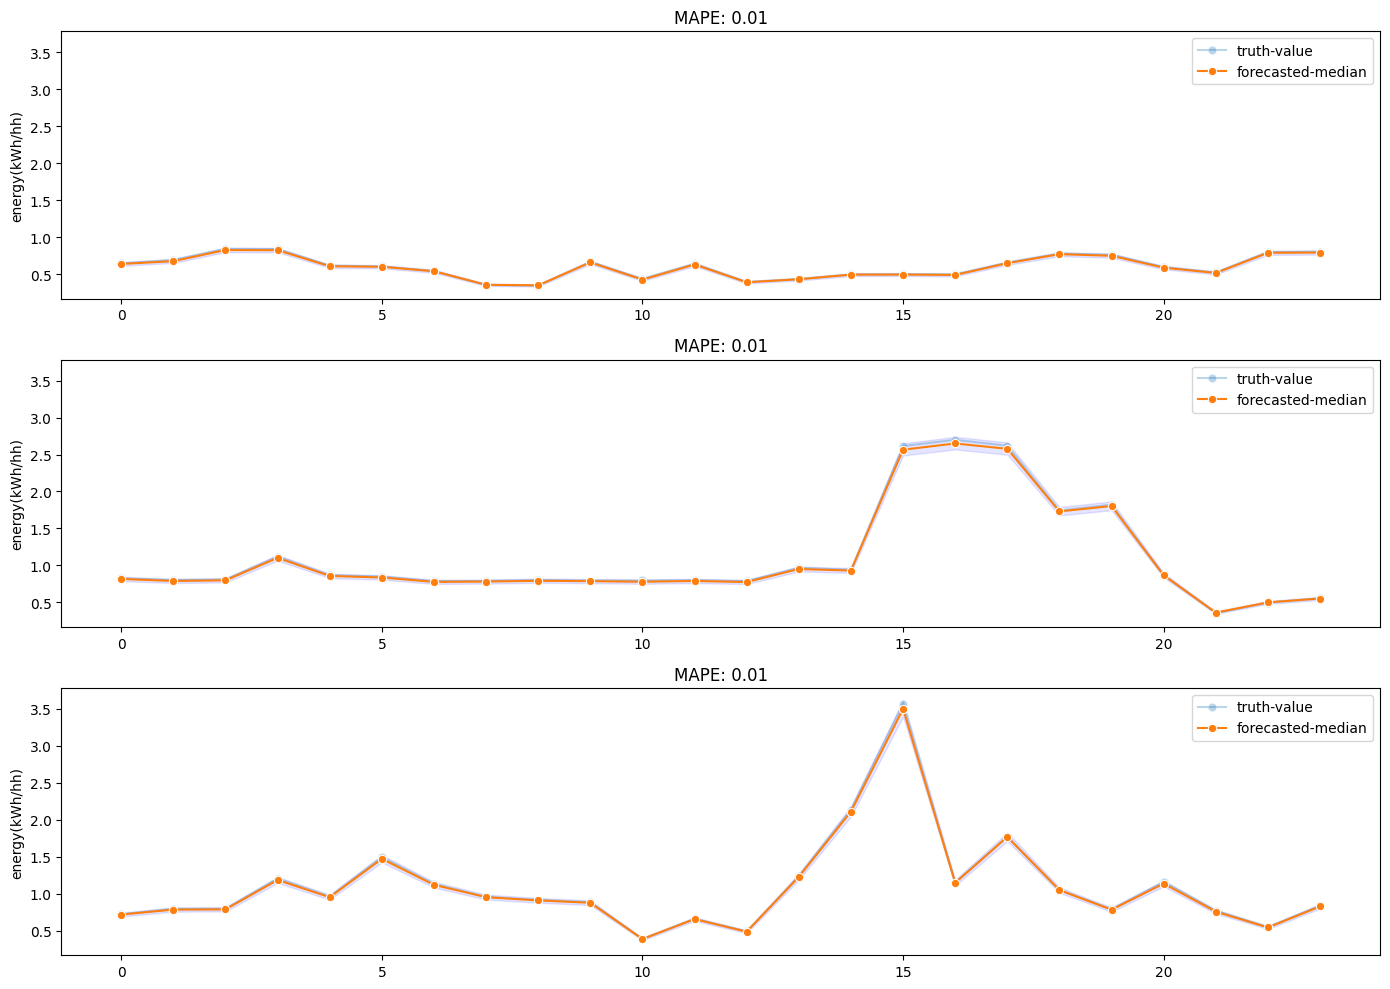

In [86]:
plot_forecast(y_pred, y_test, 3, 24, skip=(24*24))

### Hyperparameter Tuning for Quantile-GRU

1. Add 1 GRU Layer
2. Add 2 GRU Layer
3. Add 1 Dense Layer

In [101]:
from tensorflow.keras.layers import (
  Dense, GRU, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Create Model
input_layer = Input(shape=(1, X_train.shape[2]))
layer = GRU(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
  }
)

history = model.fit(
  X_train,
  [y_train, y_train, y_train],
  epochs=50,
  validation_data=(X_test, [y_test, y_test, y_test]),
  batch_size=168,
  callbacks=[earlystop]
)

Epoch 1/50
4087/4087 [==============================] - 37s 9ms/step - loss: 0.3912 - output_20_loss: 0.0503 - output_50_loss: 0.0819 - output_80_loss: 0.0721 - val_loss: 0.1189 - val_output_20_loss: 0.0265 - val_output_50_loss: 0.0356 - val_output_80_loss: 0.0274
Epoch 2/50
4087/4087 [==============================] - 36s 9ms/step - loss: 0.1092 - output_20_loss: 0.0229 - output_50_loss: 0.0339 - output_80_loss: 0.0255 - val_loss: 0.1032 - val_output_20_loss: 0.0258 - val_output_50_loss: 0.0329 - val_output_80_loss: 0.0186
Epoch 3/50
4087/4087 [==============================] - 36s 9ms/step - loss: 0.0917 - output_20_loss: 0.0188 - output_50_loss: 0.0276 - output_80_loss: 0.0203 - val_loss: 0.0684 - val_output_20_loss: 0.0174 - val_output_50_loss: 0.0157 - val_output_80_loss: 0.0106
Epoch 4/50
4087/4087 [==============================] - 34s 8ms/step - loss: 0.0866 - output_20_loss: 0.0176 - output_50_loss: 0.0257 - output_80_loss: 0.0189 - val_loss: 0.0656 - val_output_20_loss: 0.010

In [102]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1, 134)]     0           []                               
                                                                                                  
 gru_6 (GRU)                    (None, 1, 100)       70800       ['input_6[0][0]']                
                                                                                                  
 dropout_5 (Dropout)            (None, 1, 100)       0           ['gru_6[0][0]']                  
                                                                                                  
 time_distributed_10 (TimeDistr  (None, 1, 168)      16968       ['dropout_5[0][0]']              
 ibuted)                                                                                    

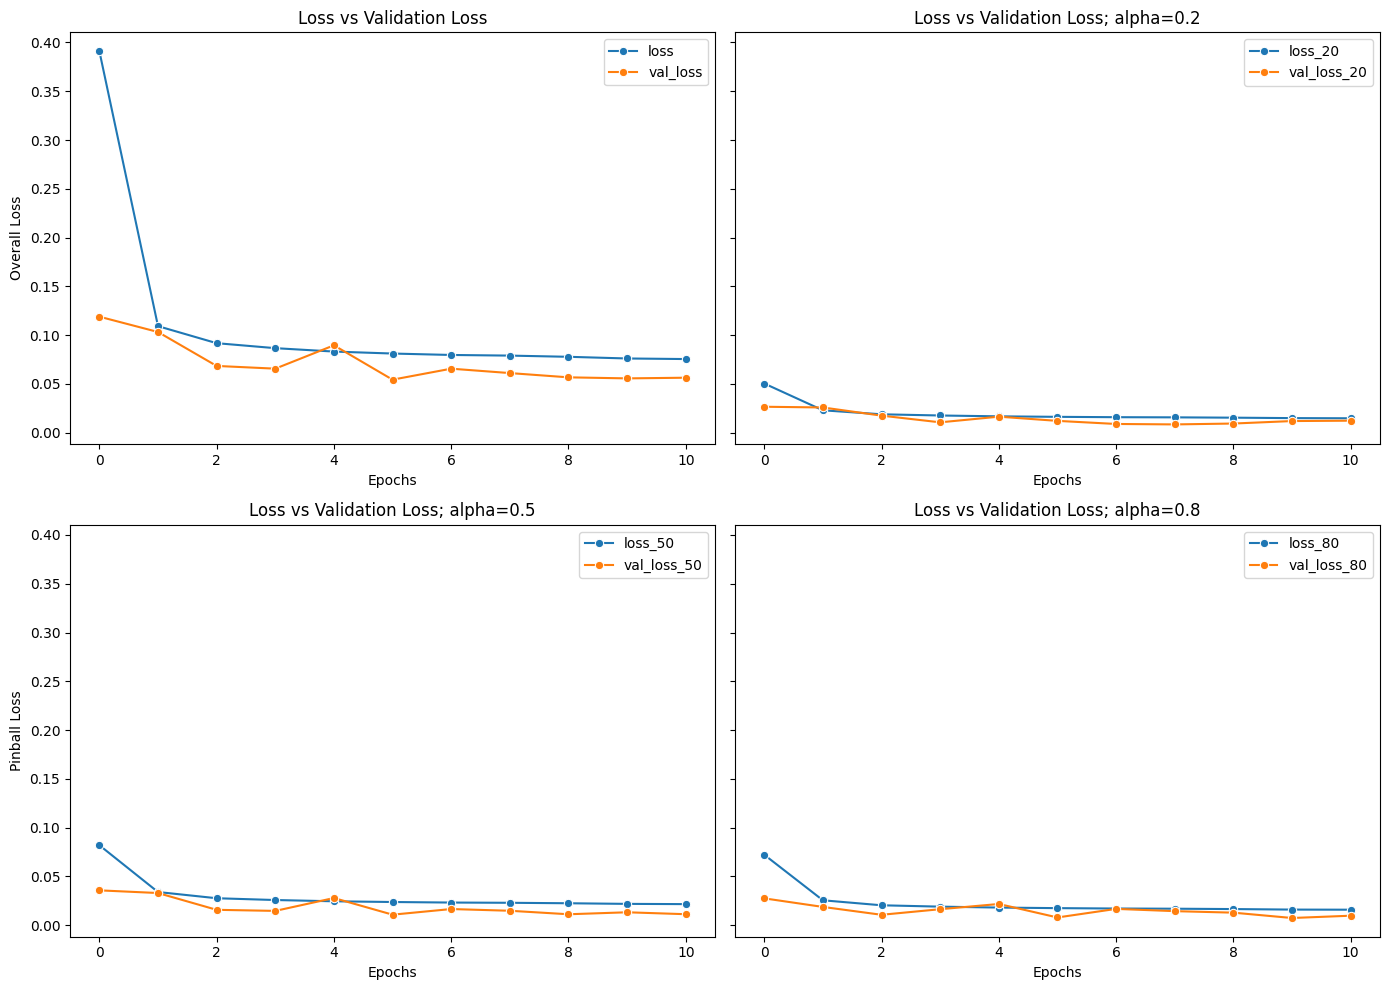

In [103]:
plot_training_metrics(history)

In [104]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional array
y_pred = pd.DataFrame({
  'pred_0.2': y_pred[0].ravel(),
  'pred_0.5': y_pred[1].ravel(),
  'pred_0.8': y_pred[2].ravel()
})

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 4s 2ms/step
RMSE: 0.03978074379605905
MSE: 0.001582507576967691
MAE: 0.022445752623184784
MAPE: 0.10146072688287135
R2 Score: 0.9958546549268279
Adjusted R2 Score: 0.9958546006065276
Pinball loss with alpha 0.2: 0.0479760817610207
Pinball loss with alpha 0.5: 0.011222876311592392
Pinball loss with alpha 0.8: 0.035573495501805406


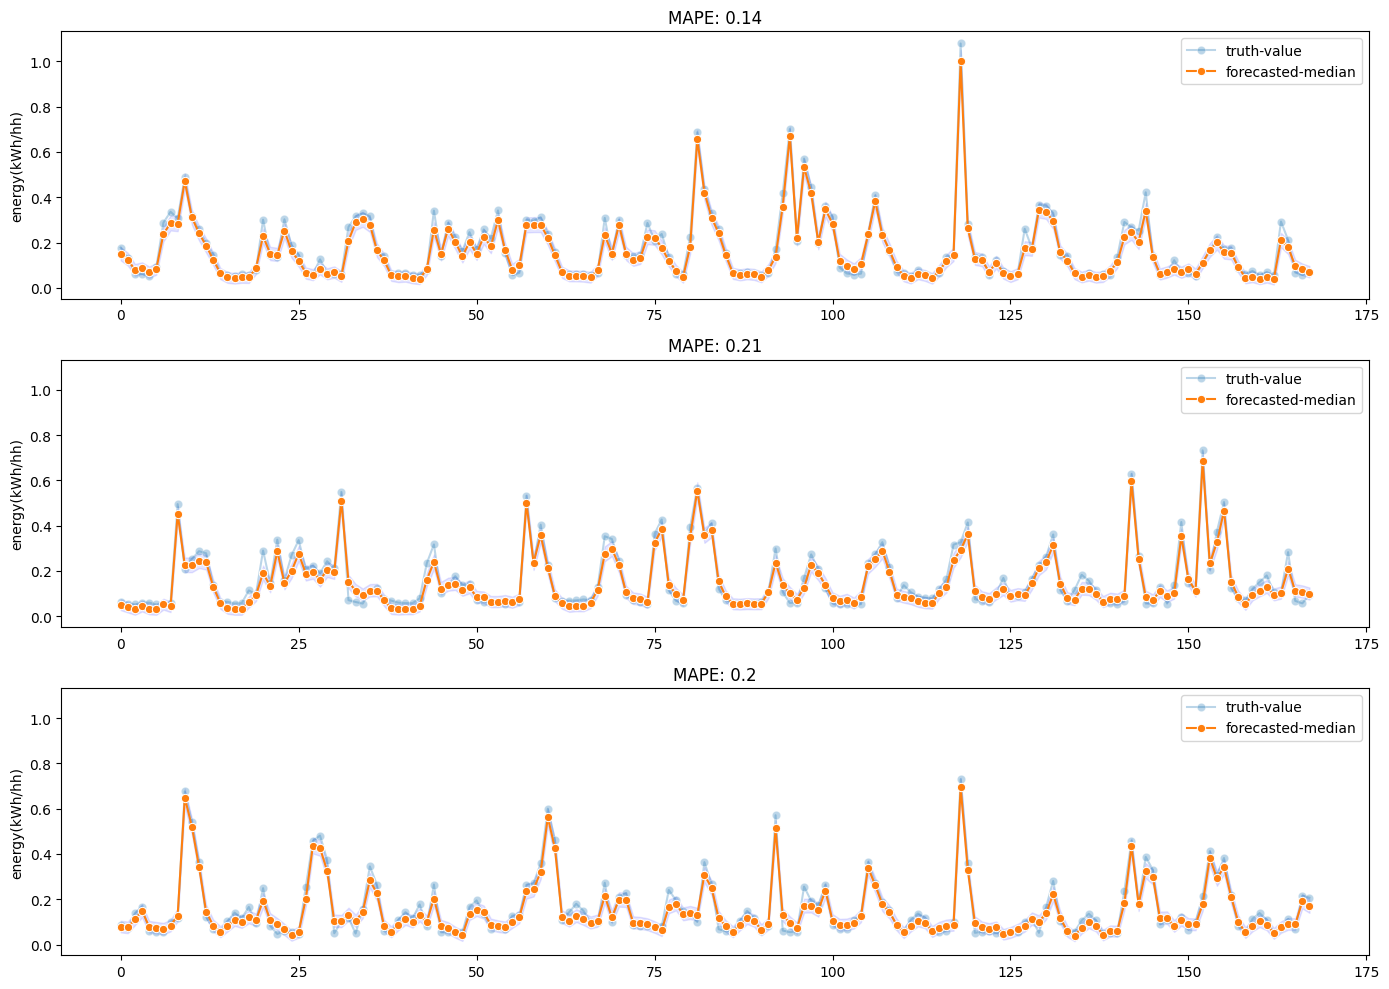

In [99]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

In [105]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, GRU, TimeDistributed, Dropout, Input
)
import keras_tuner as kt

class GRUTunedModel(kt.HyperModel):

    def build(self, hyperparameters):
        # for reproducibility
        tf.random.set_seed(42)
        tf.keras.utils.set_random_seed(42)
        tf.config.experimental.enable_op_determinism()

        hp_lstm_units = hyperparameters.Int("lstm_units", min_value=100, max_value=300, step=100)
        hp_dropout_rate = hyperparameters.Choice("dropout", values=[0.2, 0.3, 0.4, 0.5])
        hp_learning_rate = hyperparameters.Choice("learning_rate", values=[0.001, 0.0001, 0.003, 0.0003])

        # input 
        input_layer = Input(shape=(1, X_train.shape[2]))

        # stacked gru
        layer = GRU(hp_lstm_units, return_sequences=True)(input_layer)
        layer = Dropout(hp_dropout_rate)(layer)

        # full connected layer
        layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
        layer = TimeDistributed(Dense(64, activation='relu'))(layer)

        # output
        output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
        output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
        output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
        model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss={
                "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
                "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
                "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
            }
        )

        return model

    def fit(self, hyperparameters, model, *args, **kwargs):
        # for reproducibility
        tf.random.set_seed(42)
        tf.keras.utils.set_random_seed(42)
        tf.config.experimental.enable_op_determinism()
        
        return model.fit(
            *args,
            batch_size=hyperparameters.Choice("batch_size", [168, 336, 504]),
            **kwargs,
        )

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner = kt.Hyperband(
  GRUTunedModel(),
  objective='val_loss',
  seed=42,
  max_epochs=50,
  factor=3,
  directory='quantile_gru_tuned', # path to save the model tuning data
  project_name="tune_quantile_gru",
  overwrite=False
)
tuner.search(X_train, [y_train, y_train, y_train], epochs=50, validation_data=(X_test, [y_test, y_test, y_test]), callbacks=[earlystop])

Trial 90 Complete [00h 16m 38s]
val_loss: 0.025981219485402107

Best val_loss So Far: 0.02103019319474697
Total elapsed time: 03h 47m 07s


In [106]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'lstm_units': 300,
 'dropout': 0.2,
 'learning_rate': 0.0001,
 'batch_size': 168,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [107]:
# input 
input_layer = Input(shape=(1, X_train.shape[2]))

# stacked lstm
layer = GRU(300, return_sequences=True)(input_layer)
layer = Dropout(0.2)(layer)

# full connected layer
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)

# output
output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
        "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
        "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
    }
)

history = model.fit(
    X_train,
    [y_train, y_train, y_train],
    epochs=50,
    validation_split=0.2,
    batch_size=168,
    callbacks=[earlystop]
)

c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/50
3270/3270 [==============================] - 30s 9ms/step - loss: 3.6342 - output_20_loss: 0.0630 - output_50_loss: 0.1115 - output_80_loss: 0.1083 - val_loss: 0.2207 - val_output_20_loss: 0.0470 - val_output_50_loss: 0.0756 - val_output_80_loss: 0.0706
Epoch 2/50
3270/3270 [==============================] - 28s 8ms/step - loss: 0.2568 - output_20_loss: 0.0561 - output_50_loss: 0.0931 - output_80_loss: 0.0842 - val_loss: 0.1948 - val_output_20_loss: 0.0434 - val_output_50_loss: 0.0681 - val_output_80_loss: 0.0622
Epoch 3/50
3270/3270 [==============================] - 28s 8ms/step - loss: 0.2377 - output_20_loss: 0.0537 - output_50_loss: 0.0866 - output_80_loss: 0.0773 - val_loss: 0.1813 - val_output_20_loss: 0.0418 - val_output_50_loss: 0.0633 - val_output_80_loss: 0.0569
Epoch 4/50
3270/3270 [==============================] - 27s 8ms/step - loss: 0.2255 - output_20_loss: 0.0520 - output_50_loss: 0.0821 - output_80_loss: 0.0724 - val_loss: 0.1737 - val_output_20_loss: 0.040

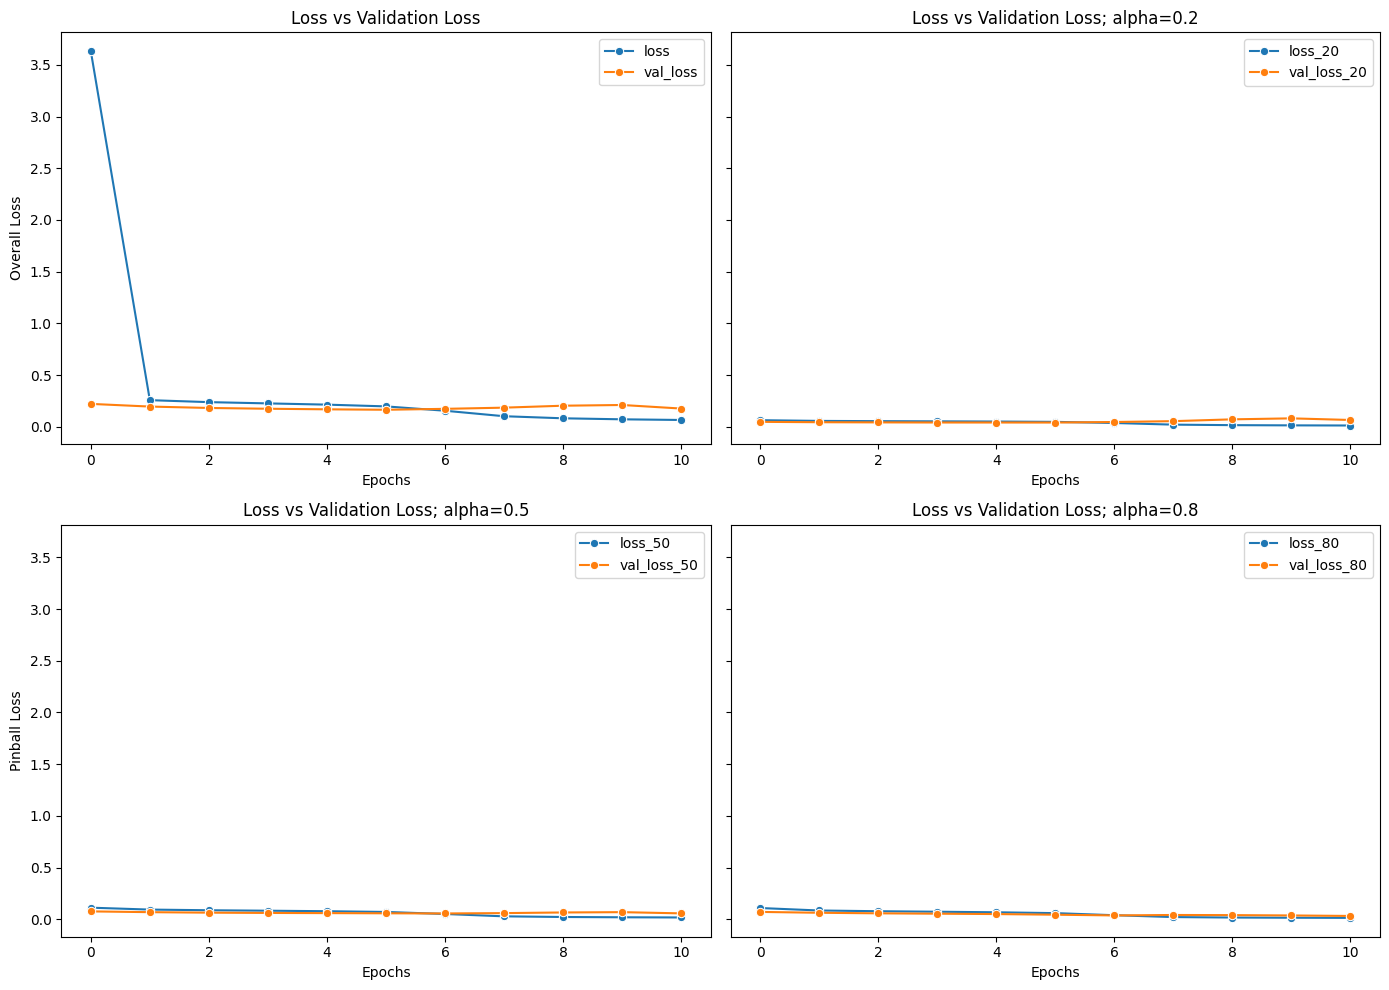

In [108]:
plot_training_metrics(history)

In [109]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional array
y_pred = pd.DataFrame({
  'pred_0.2': y_pred[0].ravel(),
  'pred_0.5': y_pred[1].ravel(),
  'pred_0.8': y_pred[2].ravel()
})

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 5s 2ms/step
RMSE: 0.060279683253598476
MSE: 0.00363364021315416
MAE: 0.032598574809101354
MAPE: 0.12345408310767395
R2 Score: 0.9908257315355875
Adjusted R2 Score: 0.990825611316641
Pinball loss with alpha 0.2: 0.03376324882008805
Pinball loss with alpha 0.5: 0.016299287404550677
Pinball loss with alpha 0.8: 0.037086173343643676


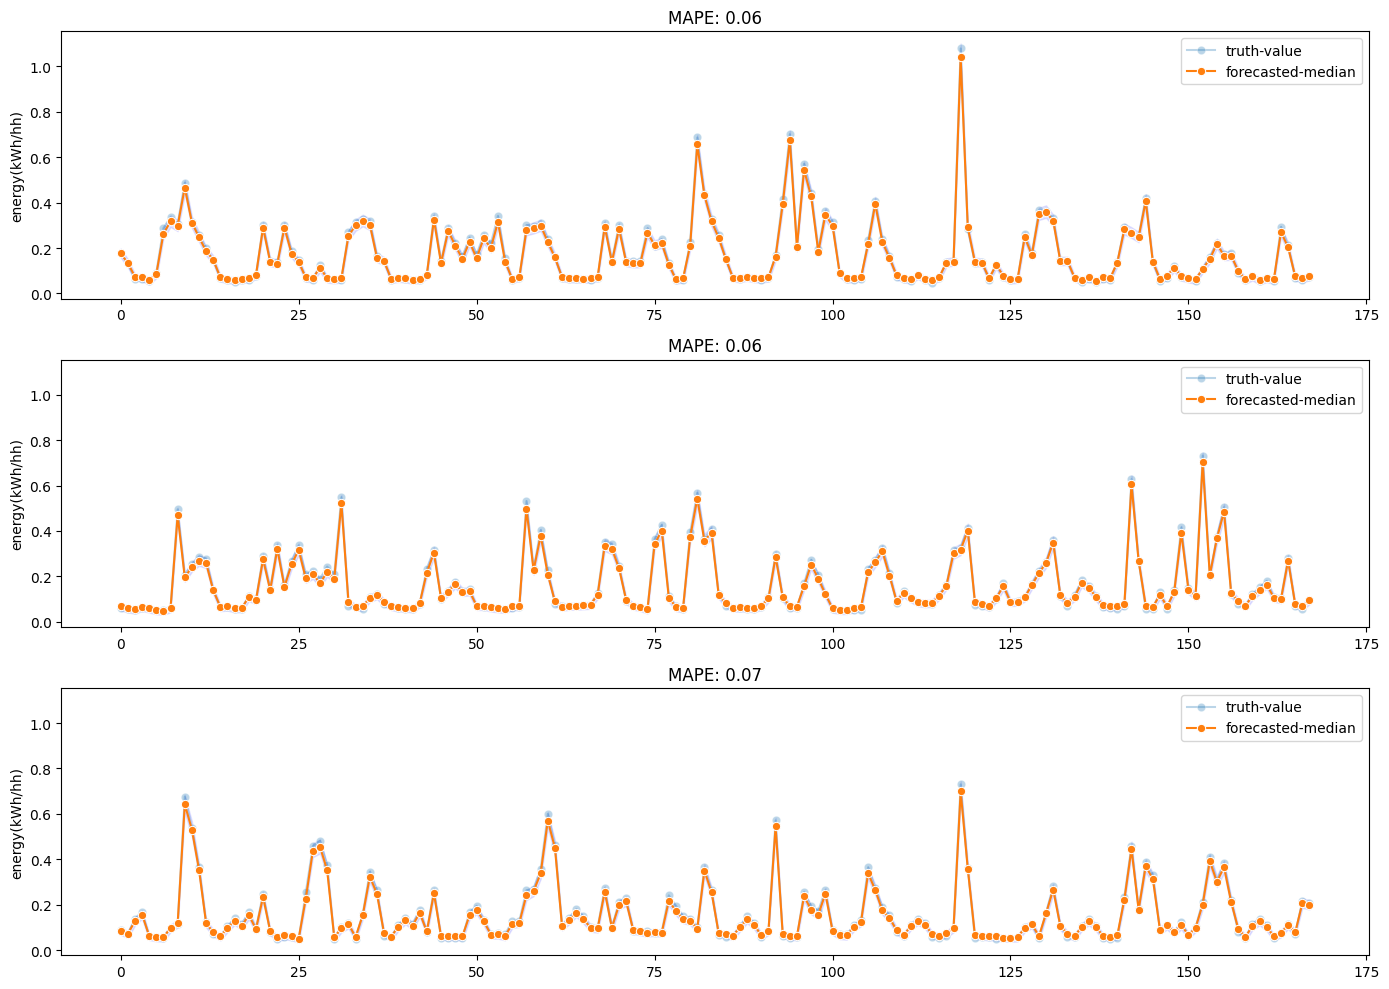

In [110]:
plot_forecast(y_pred, y_test, 3, 168, skip=(168*24))